In [11]:
# Continuous-time solver for HH–F and HH–HH trading model
# Generator–adjoint method (after J. Fernández-Villaverde’s slides)
#
# This module builds:
#  - HJB operator A (jump generator) + price flow vector phi
#  - Backward-Euler (implicit) HJB updater for contraction
#  - KFE updater using the adjoint (A.T) with mass preservation
#  - Flipper block (2×2) and price updates via simple grid search
#
# The code is organized to be easy to wire into experiments.
# It is intentionally light on dependencies (NumPy only).

from dataclasses import dataclass
import numpy as np
import time
# ---------------------------
# Parameters and grid
# ---------------------------

@dataclass
class Params:
    r: float        # discount rate
    gamma: float    # type redraw rate
    rho: float      # HH-HH meeting rate
    lam: float      # HH-F meeting rate (lambda)
    s: float        # total share of owner-occupied housing among agents (HH owners + F(1))
    f: float        # flippers share (F(0)+F(1)=f)
    delta_bar: float = 1.0

@dataclass
class Grid:
    delta: np.ndarray  # shape (N,)
    w: np.ndarray      # weights, sum to 1

def make_uniform_grid(N:int, delta_bar:float=1.0)->Grid:
    delta = np.linspace(0.0, delta_bar, N)
    # simple trapezoidal weights on [0,delta_bar]
    w = np.ones(N) * (delta_bar/(N-1))
    w[0] *= 0.5; w[-1]*=0.5
    # normalize to sum 1 for convenience
    w = w / w.sum()
    return Grid(delta=delta, w=w)

# ---------------------------
# Helpers
# ---------------------------

def stacked(x0, x1):
    """Stack two length-N arrays into a single 2N vector [x0; x1]."""
    return np.concatenate([x0, x1], axis=0)

def unstack(v):
    """Split 2N vector into (v0, v1)."""
    N2 = v.shape[0]
    N = N2//2
    return v[:N], v[N:]

def sort_by(values):
    """Return (order, rank) where rank[i] is the position of i in 'order'"""
    order = np.argsort(values, kind="mergesort")
    rank = np.empty_like(order)
    rank[order] = np.arange(order.size)
    return order, rank

# ---------------------------
# Acceptance regions
# ---------------------------

def build_acceptance(DeltaV, P0, P1):
    """
    HH-F acceptance sets:
      owners sell to F if DeltaV <= P0,
      nonowners buy from F if DeltaV >= P1.
    """
    sell_to_F = (DeltaV <= P0).astype(float)   # 1->0
    buy_from_F = (DeltaV >= P1).astype(float)  # 0->1
    return sell_to_F, buy_from_F

# ---------------------------
# Partner masses for HH-HH
# ---------------------------

def partner_cumsums(DeltaV, H0_tilde, H1_tilde):
    """
    Given DeltaV, compute for each i:
      M0_up[i]   = sum_{j: DV[j] >= DV[i]} H0_tilde[j]
      M1_down[i] = sum_{j: DV[j] <= DV[i]} H1_tilde[j]
      S0_up[i]   = sum_{j: DV[j] >= DV[i]} H0_tilde[j]*DV[j]
      S1_down[i] = sum_{j: DV[j] <= DV[i]} H1_tilde[j]*DV[j]
    """
    N = DeltaV.size
    order, rank = sort_by(DeltaV)  # ascending

    H0_ord = H0_tilde[order]
    H1_ord = H1_tilde[order]
    DV_ord = DeltaV[order]

    cum_H1 = np.cumsum(H1_ord)
    cum_H1DV = np.cumsum(H1_ord * DV_ord)

    cum_H0 = np.cumsum(H0_ord)
    cum_H0DV = np.cumsum(H0_ord * DV_ord)
    tot_H0 = cum_H0[-1]
    tot_H0DV = cum_H0DV[-1]

    M1_down = cum_H1[rank]                 # <= current DV
    S1_down = cum_H1DV[rank]

    # For >= current DV we subtract the prefix before rank
    pref_H0 = np.where(rank>0, cum_H0[rank-1], 0.0)
    pref_H0DV = np.where(rank>0, cum_H0DV[rank-1], 0.0)
    M0_up = tot_H0 - pref_H0
    S0_up = tot_H0DV - pref_H0DV

    return M0_up, M1_down, S0_up, S1_down

# ---------------------------
# Hazards and generator A
# ---------------------------

def build_hazards(params:Params, sell_to_F, buy_from_F, M0_up, M1_down, F0, F1):
    """
    Returns the four hazard arrays (length N each):
      alphaF_10: owner->nonowner via F
      alphaF_01: nonowner->owner via F
      alphaHH_10: owner->nonowner via HH-HH
      alphaHH_01: nonowner->owner via HH-HH
    """
    lam, rho = params.lam, params.rho
    alphaF_10 = lam * F0 * sell_to_F           # owners -> 0
    alphaF_01 = lam * F1 * buy_from_F          # nonowners -> 1
    alphaHH_10 = rho * M0_up
    alphaHH_01 = rho * M1_down
    return alphaF_10, alphaF_01, alphaHH_10, alphaHH_01

def assemble_A(params:Params, grid:Grid, alphaF_10, alphaF_01, alphaHH_10, alphaHH_01):
    """
    Build the 2N x 2N generator A (jump operator only).
    Block structure over states h=0,1 and type grid.
    Includes type-redraw rank-1 operator per block.
    """
    N = grid.delta.size
    gamma = params.gamma
    w = grid.w

    # Diagonals for each block
    d0 = -(gamma + alphaF_01 + alphaHH_01)   # for V0 rows
    d1 = -(gamma + alphaF_10 + alphaHH_10)   # for V1 rows

    # Start with zeros
    A = np.zeros((2*N, 2*N))

    # Top-left (V0,V0)
    A[:N, :N] += np.diag(d0)
    # add redraw inflow: + gamma * (1 w^T)
    A[:N, :N] += gamma * np.outer(np.ones(N), w)

    # Bottom-right (V1,V1)
    A[N:, N:] += np.diag(d1)
    A[N:, N:] += gamma * np.outer(np.ones(N), w)

    # Cross blocks (same index jump 0<->1)
    A[:N, N:] += np.diag(alphaF_01 + alphaHH_01)   # V0 row receives from V1
    A[N:, :N] += np.diag(alphaF_10 + alphaHH_10)   # V1 row receives from V0

    return A

def price_flow(params:Params, DeltaV, M0_up, M1_down, S0_up, S1_down):
    """
    Compute the price flow vector phi (2N,) implied by HH-HH trades with
    midpoint pricing P=(DV_i+DV_j)/2. HH-F price flows can be included too
    but are redundant in value differences.
    """
    rho = params.rho
    N = DeltaV.size

    phi1 = 0.5 * rho * ( M0_up * DeltaV + S0_up )   # owners receive price
    phi0 = -0.5 * rho * ( M1_down * DeltaV + S1_down )  # nonowners pay price

    return stacked(phi0, phi1)

# ---------------------------
# HJB updater (implicit/backward-Euler)
# ---------------------------

def hjb_implicit_update(params:Params, A, b, phi, V_old, dt=10.0):
    """
    One backward-Euler step:
      ((r + 1/dt) I - A) V_new = b + phi + V_old/dt
    Unconditionally stable (contraction for any dt>0).
    """
    r = params.r
    N2 = A.shape[0]
    K = (r + 1.0/dt) * np.eye(N2) - A
    rhs = b + phi + V_old / dt
    V_new = np.linalg.solve(K, rhs)
    return V_new

# ---------------------------
# KFE updater (adjoint implicit step)
# ---------------------------

def kfe_implicit_step(A, H_tilde, dt=10.0):
    """
    Implicit step for the adjoint dynamics:
      (I - dt * A^T) H^{n} = H^{n-1}
    """
    N2 = A.shape[0]
    K = np.eye(N2) - dt * A.T
    H_new = np.linalg.solve(K, H_tilde)
    return H_new

def renormalize_H(H_tilde, params:Params):
    """
    Enforce constraints:
      sum(H0+H1)=1
      sum(H1)+F1 = s   (we return only H; caller sets F1)
    Here we just normalize total to 1; the split with s is enforced when
    updating F below.
    """
    tot = H_tilde.sum()
    if tot <= 0:
        return H_tilde
    return H_tilde / tot

# ---------------------------
# Flipper block
# ---------------------------

def flipper_intensities(params:Params, DeltaV, H0_tilde, H1_tilde, P0, P1):
    lam = params.lam
    mass_owners_accept = H1_tilde[DeltaV <= P0].sum()
    mass_nonowners_accept = H0_tilde[DeltaV >= P1].sum()
    q_b = lam * mass_owners_accept   # seller HH met by flipper-buyer
    q_s = lam * mass_nonowners_accept  # buyer HH met by flipper-seller
    return q_b, q_s

def solve_flipper_values(r, q_b, q_s, P0, P1):
    """
    2x2 linear system:
      (r+q_b)W0 - q_b W1 = -P0 q_b
      -q_s W0 + (r+q_s) W1 = +P1 q_s
    """
    K = np.array([[r+q_b, -q_b],
                  [-q_s,  r+q_s]], dtype=float)
    rhs = np.array([-P0*q_b, +P1*q_s], dtype=float)
    W0, W1 = np.linalg.solve(K, rhs)
    return W0, W1, (W1 - W0)

def update_prices_by_grid(params:Params, DeltaV, H0_tilde, H1_tilde,
                          P0, P1, grid_pts=51):
    """
    Simple robust price updates via grid search over DV support.
    Optimizes each side holding the other price fixed (Gauss-Seidel).
    """
    r = params.r
    dv_min, dv_max = float(DeltaV.min()), float(DeltaV.max())
    cand = np.linspace(dv_min, dv_max, grid_pts)

    # Update P0
    best_val, best_P0 = -1e18, P0
    for p0 in cand:
        q_b, q_s = flipper_intensities(params, DeltaV, H0_tilde, H1_tilde, p0, P1)
        W0, W1, dW = solve_flipper_values(r, q_b, q_s, p0, P1)
        obj = q_b * (-p0 + dW)   # flipper as buyer
        if obj > best_val:
            best_val, best_P0 = obj, p0

    P0_new = best_P0

    # Update P1
    best_val, best_P1 = -1e18, P1
    for p1 in cand:
        q_b, q_s = flipper_intensities(params, DeltaV, H0_tilde, H1_tilde, P0_new, p1)
        W0, W1, dW = solve_flipper_values(r, q_b, q_s, P0_new, p1)
        obj = q_s * (p1 - dW)   # flipper as seller
        if obj > best_val:
            best_val, best_P1 = obj, p1

    return P0_new, best_P1

def split_flippers(params:Params, DeltaV, H0_tilde, H1_tilde, P0, P1):
    """Adjoint split: A_F^T F = 0 with F0+F1=f."""
    q_b, q_s = flipper_intensities(params, DeltaV, H0_tilde, H1_tilde, P0, P1)
    if q_b + q_s <= 0:
        return 0.5*params.f, 0.5*params.f
    F1 = params.f * (q_b / (q_b + q_s))
    F0 = params.f - F1
    return F0, F1

# ---------------------------
# Main outer iteration
# ---------------------------

def solve_model(params:Params, grid:Grid,
                max_outer=50, tol=1e-6,
                hjb_dt=10.0, hjb_steps=5,
                kfe_dt=10.0, kfe_steps=5,
                verbose=True, seed=0):
    """
    Returns a dict with equilibrium objects.
    """
    rng = np.random.default_rng(seed)
    N = grid.delta.size

    # Initial distributions (uniform across types)
    H_total = np.ones(N) * (1.0 / params.delta_bar)  # pdf of G (uniform here)
    H1_pdf = 0.5 * H_total  # initial split (will be adjusted)
    H0_pdf = H_total - H1_pdf

    H0_tilde = H0_pdf * grid.w
    H1_tilde = H1_pdf * grid.w

    # Initial values
    V0 = np.zeros(N)
    V1 = grid.delta / (params.r + params.gamma + 1e-9)  # crude
    V = stacked(V0, V1)
    DeltaV = V1 - V0

    # Initial prices (support of DV) and flippers split
    P0 = np.quantile(DeltaV, 0.25)
    P1 = np.quantile(DeltaV, 0.75)
    F0, F1 = 0.5*params.f, 0.5*params.f

    for it in range(max_outer):
        # 1) Acceptance and partner masses
        sell_to_F, buy_from_F = build_acceptance(DeltaV, P0, P1)
        M0_up, M1_down, S0_up, S1_down = partner_cumsums(DeltaV, H0_tilde, H1_tilde)

        # 2) Hazards and generator A, price flow phi
        aF10, aF01, aHH10, aHH01 = build_hazards(params, sell_to_F, buy_from_F, M0_up, M1_down, F0, F1)
        A = assemble_A(params, grid, aF10, aF01, aHH10, aHH01)
        b = stacked(np.zeros(N), grid.delta)  # flow: only owners get delta
        phi = price_flow(params, DeltaV, M0_up, M1_down, S0_up, S1_down)

        # 3) Policy evaluation: implicit HJB steps (backward-Euler contraction)
        V_old = V.copy()
        for _ in range(hjb_steps):
            V = hjb_implicit_update(params, A, b, phi, V, dt=hjb_dt)

        V0, V1 = unstack(V)
        DeltaV = V1 - V0

        # (Optional) small policy iteration on acceptance sets
        sell_to_F_new, buy_from_F_new = build_acceptance(DeltaV, P0, P1)
        if np.any(sell_to_F_new != sell_to_F) or np.any(buy_from_F_new != buy_from_F):
            # Recompute hazards and do one more evaluation to settle policy
            aF10, aF01, aHH10, aHH01 = build_hazards(params, sell_to_F_new, buy_from_F_new, M0_up, M1_down, F0, F1)
            A = assemble_A(params, grid, aF10, aF01, aHH10, aHH01)
            phi = price_flow(params, DeltaV, M0_up, M1_down, S0_up, S1_down)
            for _ in range(max(1, hjb_steps//2)):
                V = hjb_implicit_update(params, A, b, phi, V, dt=hjb_dt)
            V0, V1 = unstack(V)
            DeltaV = V1 - V0

        # 4) Flippers: prices and split
        P0, P1 = update_prices_by_grid(params, DeltaV, H0_tilde, H1_tilde, P0, P1, grid_pts=51)
        F0, F1 = split_flippers(params, DeltaV, H0_tilde, H1_tilde, P0, P1)

        # 5) KFE implicit steps (adjoint), with renormalization
        H_tilde = stacked(H0_tilde, H1_tilde)
        for _ in range(kfe_steps):
            H_tilde = kfe_implicit_step(A, H_tilde, dt=kfe_dt)
            H_tilde = renormalize_H(H_tilde, params)
        H0_tilde, H1_tilde = unstack(H_tilde)

        # enforce owner share target using flippers split
        target_H1_mass = max(1e-12, params.s - F1)
        total_mass = H0_tilde.sum() + H1_tilde.sum()
        if total_mass <= 0:
            total_mass = 1.0
        # rescale while preserving total 1
        H1_tilde *= target_H1_mass / max(1e-12, H1_tilde.sum())
        H0_tilde *= (1.0 - target_H1_mass) / max(1e-12, H0_tilde.sum())

        # 6) Check
        diff = max(np.max(np.abs(V - V_old)), np.abs((H0_tilde+H1_tilde).sum() - 1.0))
        if verbose:
            print(f"[it {it:02d}] P0={P0:.4f} P1={P1:.4f}  F1={F1:.4f}  ||Δ||={diff:.2e}")
        if diff < tol:
            break
    print(f"Converged in {it+1} iters with ||Δ||={diff:.2e}")
    return dict(delta=grid.delta, w=grid.w,
                V0=V0, V1=V1, DeltaV=DeltaV,
                H0_tilde=H0_tilde, H1_tilde=H1_tilde,
                P0=P0, P1=P1, F0=F0, F1=F1,
                A=A, b=b)

# ---------------------------
# Example (very small run)
# ---------------------------

if __name__ == "__main__":
    # Simple quick demonstration (tiny N to run fast here)
    N = 1001
    grid = make_uniform_grid(N, 1.0)
    params = Params(r=0.0361577940, gamma=0.0867540457, rho=0.4133277998, lam=3.9750228339, s=0.6884162140, f=0.0048366897)
    start_time = time.time()

    out = solve_model(params, grid, max_outer=5, tol=1e-10,
                      hjb_dt=10.0, hjb_steps=30,
                      kfe_dt=10.0, kfe_steps=30,
                      verbose=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time for operations: {elapsed_time:.2f} seconds")
    # Print a couple of summary numbers
    print("\nSummary (demo run):")
    print("  P0, P1 =", out['P0'], out['P1'])
    print("  F split =", out['F0'], out['F1'])
    print("  mass check =", float((out['H0_tilde']+out['H1_tilde']).sum()))


[it 00] P0=4.5711 P1=7.0002  F1=0.0020  ||Δ||=9.20e+00
[it 01] P0=5.9092 P1=7.9593  F1=0.0014  ||Δ||=1.71e+00
[it 02] P0=6.7811 P1=8.7977  F1=0.0014  ||Δ||=9.06e-01
[it 03] P0=6.8798 P1=9.3736  F1=0.0010  ||Δ||=7.35e-01
[it 04] P0=8.0323 P1=9.8480  F1=0.0012  ||Δ||=7.01e-01
Converged in 5 iters with ||Δ||=7.01e-01
Total time for operations: 53.48 seconds

Summary (demo run):
  P0, P1 = 8.03229919859845 9.847950723657412
  F split = 0.0035881681513230236 0.001248521548676976
  mass check = 1.0


In [36]:
# ================== CUTTOFF–POLICY ITERATION (GENERATOR–ADJOINT) ==================
# - Continuous-time HJB with jump-generator A and implicit (backward-Euler) updates
# - KFE via adjoint (A^T) implicit steps
# - HH–F acceptance via CUT-OFFS (δ1*, δ0*), not price thresholds
# - HH–HH partner masses via ΔV ordering (cumsums)
# - Flipper (2×2) block for W and F split
# - Cutoff updates: greedy (profit-max) or FOC residual roots
# ==================================================================================

from dataclasses import dataclass
import numpy as np

# ---------------------------
# Parameters and grid
# ---------------------------

@dataclass
class Params:
    r: float        # discount rate
    gamma: float    # type redraw rate
    rho: float      # HH-HH meeting rate
    lam: float      # HH-F meeting rate (lambda)
    s: float        # owner share target (HH owners + F(1))
    f: float        # flippers share (F(0)+F(1)=f)
    delta_bar: float = 1.0

@dataclass
class Grid:
    delta: np.ndarray  # (N,)
    w: np.ndarray      # (N,), weights sum to 1

def make_uniform_grid(N:int, delta_bar:float=1.0)->Grid:
    delta = np.linspace(0.0, delta_bar, N)
    # trapezoid weights, normalized to 1
    w = np.ones(N) * (delta_bar/(N-1))
    w[0] *= 0.5; w[-1] *= 0.5
    w = w / w.sum()
    return Grid(delta=delta, w=w)

# ---------------------------
# Helpers
# ---------------------------

def stacked(x0, x1): return np.concatenate([x0, x1], axis=0)
def unstack(v):
    N2 = v.shape[0]; N = N2//2
    return v[:N], v[N:]

def sort_by(values):
    order = np.argsort(values, kind="mergesort")
    rank = np.empty_like(order)
    rank[order] = np.arange(order.size)
    return order, rank

# ---------------------------
# Acceptance regions (HH–F) from CUT-OFFS
# ---------------------------

def build_acceptance_cutoffs(delta, d0_star, d1_star):
    """
    Owners sell to F if δ <= δ1*
    Nonowners buy from F if δ >= δ0*
    """
    sell_to_F = (delta <= d1_star).astype(float)   # 1->0
    buy_from_F = (delta >= d0_star).astype(float)  # 0->1
    return sell_to_F, buy_from_F

# ---------------------------
# Partner masses for HH-HH (by ΔV ordering)
# ---------------------------

def partner_cumsums(DeltaV, H0_tilde, H1_tilde):
    """
    M0_up[i]   = sum_{DV[j]>=DV[i]} H0_tilde[j]
    M1_down[i] = sum_{DV[j]<=DV[i]} H1_tilde[j]
    S0_up[i]   = sum_{DV[j]>=DV[i]} H0_tilde[j]*DV[j]
    S1_down[i] = sum_{DV[j]<=DV[i]} H1_tilde[j]*DV[j]
    """
    order, rank = sort_by(DeltaV)  # ascending
    H0o = H0_tilde[order]; H1o = H1_tilde[order]; DVo = DeltaV[order]

    cum_H1 = np.cumsum(H1o);  cum_H1DV = np.cumsum(H1o * DVo)
    cum_H0 = np.cumsum(H0o);  cum_H0DV = np.cumsum(H0o * DVo)

    tot_H0 = cum_H0[-1]; tot_H0DV = cum_H0DV[-1]

    M1_down = cum_H1[rank]
    S1_down = cum_H1DV[rank]

    pref_H0   = np.where(rank>0, cum_H0[rank-1], 0.0)
    pref_H0DV = np.where(rank>0, cum_H0DV[rank-1], 0.0)
    M0_up = tot_H0 - pref_H0
    S0_up = tot_H0DV - pref_H0DV
    return M0_up, M1_down, S0_up, S1_down

# ---------------------------
# Hazards and generator A
# ---------------------------

def build_hazards(params:Params, sell_to_F, buy_from_F, M0_up, M1_down, F0, F1):
    lam, rho = params.lam, params.rho
    alphaF_10 = lam * F0 * sell_to_F    # owners -> nonowners via F
    alphaF_01 = lam * F1 * buy_from_F   # nonowners -> owners via F
    alphaHH_10 = rho * M0_up
    alphaHH_01 = rho * M1_down
    return alphaF_10, alphaF_01, alphaHH_10, alphaHH_01

def assemble_A(params:Params, grid:Grid, aF10, aF01, aHH10, aHH01):
    N = grid.delta.size; w = grid.w; gamma = params.gamma
    A = np.zeros((2*N, 2*N))
    # diagonals per block (outflows)
    d0 = -(gamma + aF01 + aHH01)   # for V0 equations
    d1 = -(gamma + aF10 + aHH10)   # for V1 equations
    # block (V0,V0) with redraw inflow
    A[:N,:N] += np.diag(d0) + gamma*np.outer(np.ones(N), w)
    # block (V1,V1) with redraw inflow
    A[N:,N:] += np.diag(d1) + gamma*np.outer(np.ones(N), w)
    # cross blocks (same-index 0<->1 jumps)
    A[:N, N:] += np.diag(aF01 + aHH01)   # into V0 from V1
    A[N:, :N] += np.diag(aF10 + aHH10)   # into V1 from V0
    return A

def price_flow(params:Params, DeltaV, M0_up, M1_down, S0_up, S1_down,
               aF10, aF01, P0, P1):
    """
    φ = φ^HH + φ^F.
    HH–HH midpoint pricing (depends linearly on ΔV) +
    HH–F price flows (±P0, ±P1).
      For owners:  + aF10 * P0
      For nonowners: - aF01 * P1
    """
    rho = params.rho; N = DeltaV.size
    # HH–HH price flows
    phi1 = 0.5 * rho * ( M0_up * DeltaV + S0_up )      # owners receive
    phi0 = -0.5 * rho * ( M1_down * DeltaV + S1_down ) # nonowners pay
    # HH–F price flows
    phi1 += aF10 * P0
    phi0 += -aF01 * P1
    return stacked(phi0, phi1)

# ---------------------------
# HJB implicit (contraction) and KFE adjoint
# ---------------------------

def hjb_backward_euler(params:Params, A, b, phi, V, dt=10.0, steps=4):
    r = params.r
    N2 = A.shape[0]
    K = (r + 1.0/dt) * np.eye(N2) - A
    rhs = b + phi
    for _ in range(steps):
        V = np.linalg.solve(K, rhs + V/dt)
    return V

def kfe_implicit_adjoint(A, H_tilde, dt=10.0, steps=3):
    N2 = A.shape[0]
    K = np.eye(N2) - dt * A.T
    for _ in range(steps):
        H_tilde = np.linalg.solve(K, H_tilde)
    return H_tilde

def renormalize_H(H_tilde, params:Params):
    tot = H_tilde.sum()
    return H_tilde if tot<=0 else H_tilde / tot

# ---------------------------
# Flipper block and intensities (cutoff-based)
# ---------------------------

def cdfs_and_pdfs(H0_tilde, H1_tilde, w):
    H0_cdf = np.cumsum(H0_tilde)
    H1_cdf = np.cumsum(H1_tilde)
    eps = 1e-14
    h0 = H0_tilde/np.clip(w, eps, None)
    h1 = H1_tilde/np.clip(w, eps, None)
    return H0_cdf, H1_cdf, h0, h1

def intensities_from_cutoffs(params:Params, H0_cdf, H1_cdf, i0, i1):
    lam = params.lam
    q_b = lam * H1_cdf[i1]                       # meets owners up to δ1*
    q_s = lam * (H0_cdf[-1] - H0_cdf[i0])       # meets nonowners from δ0* up
    return q_b, q_s

def solve_flipper_values(params:Params, q_b, q_s, P0, P1):
    r = params.r
    K = np.array([[r+q_b, -q_b],
                  [-q_s,  r+q_s]], dtype=float)
    rhs = np.array([-P0*q_b, +P1*q_s], dtype=float)
    W0, W1 = np.linalg.solve(K, rhs)
    return W0, W1, (W1 - W0)

def split_flippers(params:Params, q_b, q_s):
    if q_b + q_s <= 0:
        return 0.5*params.f, 0.5*params.f
    F1 = params.f * (q_b / (q_b + q_s))
    F0 = params.f - F1
    return F0, F1

# ---------------------------
# Cutoff updates: Greedy and FOC
# ---------------------------

def greedy_cutoffs(params:Params, delta, DeltaV, H0_cdf, H1_cdf, d0_prev, d1_prev, chi=0.4):
    lam = params.lam
    # profit arrays on grid
    q_b = lam * H1_cdf                      # buyers (as flipper-buyer)
    q_s = lam * (H0_cdf[-1] - H0_cdf)       # sellers (as flipper-seller)

    # We need ΔW for profit; approximate with current ΔW using cutoffs at previous step
    # (the main loop will pass an up-to-date ΔW; here we keep signature simple)
    # We'll return None and let outer loop pass ΔW in the FOC variant; for greedy,
    # use ΔW = np.median(DeltaV) as a robust fallback.
    DeltaW_guess = float(np.median(DeltaV))

    profit_b = q_b * (DeltaW_guess - DeltaV)     # maximize over δ1
    profit_s = q_s * (DeltaV - DeltaW_guess)     # maximize over δ0

    i1_new = int(np.argmax(profit_b))
    i0_new = int(np.argmax(profit_s))
    d1_new = delta[i1_new]; d0_new = delta[i0_new]

    # damp and enforce ordering
    d0 = (1-chi)*d0_prev + chi*d0_new
    d1 = (1-chi)*d1_prev + chi*d1_new
    if d1 > d0:
        mid = 0.5*(d0+d1)
        d0, d1 = max(mid, d0), min(mid, d1)  # fold toward each other
    return d0, d1, i0_new, i1_new

def foc_cutoffs(params:Params, grid:Grid, DeltaV, H0_cdf, H1_cdf, h0, h1, DeltaW, d0_prev, d1_prev, chi=0.4):
    delta = grid.delta
    # finite-diff slope of ΔV
    DVp = np.gradient(DeltaV, delta)
    # residuals on grid
    R0 = (H0_cdf[-1] - H0_cdf) * DVp - h0 * (DeltaV - DeltaW)
    R1 = H1_cdf * DVp - h1 * (DeltaW - DeltaV)

    def _root_from_residual(R):
        # try sign-change bracketing, else argmin |R|
        s = np.sign(R)
        idx = np.where(s[:-1]*s[1:]<=0)[0]
        if idx.size>0:
            # take first bracket; linear interpolation
            j = int(idx[0])
            x0,x1 = delta[j], delta[j+1]
            y0,y1 = R[j], R[j+1]
            if abs(y1-y0)>1e-14:
                x = x0 - y0*(x1-x0)/(y1-y0)
            else:
                x = 0.5*(x0+x1)
            # clamp to bracket
            x = float(np.clip(x, min(x0,x1), max(x0,x1)))
            i_closest = int(np.argmin(np.abs(delta - x)))
            return x, i_closest
        # fallback: closest to zero
        i = int(np.argmin(np.abs(R)))
        return float(delta[i]), i

    d0_new, i0_new = _root_from_residual(R0)
    d1_new, i1_new = _root_from_residual(R1)

    # damp and enforce ordering
    d0 = (1-chi)*d0_prev + chi*d0_new
    d1 = (1-chi)*d1_prev + chi*d1_new
    if d1 > d0:
        mid = 0.5*(d0+d1)
        d0, d1 = max(mid, d0), min(mid, d1)
    return d0, d1, i0_new, i1_new, R0, R1

# ---------------------------
# Main solver (cutoff policy iteration)
# ---------------------------

def solve_model_cutoffs(params:Params, grid:Grid,
                        d0_init=None, d1_init=None,
                        update_method="foc", chi=0.4,
                        max_outer=100, tol=1e-6,
                        hjb_dt=10.0, hjb_steps=4,
                        kfe_dt=10.0, kfe_steps=3,
                        verbose=True, seed=0):
    """
    update_method: "foc" (default) or "greedy"
    """
    rng = np.random.default_rng(seed)
    N = grid.delta.size; delta = grid.delta; w = grid.w

    # ---- initial distributions (uniform split)
    H_total = np.ones(N) * (1.0/params.delta_bar)
    H1_pdf = 0.5 * H_total
    H0_pdf = H_total - H1_pdf
    H0_tilde = H0_pdf * w
    H1_tilde = H1_pdf * w

    # ---- initial values
    V0 = np.zeros(N)
    V1 = delta / (params.r + params.gamma + 1e-9)
    V  = stacked(V0, V1)
    DeltaV = V1 - V0

    # ---- initial cutoffs (quantiles) if not provided
    d0 = float(delta[int(0.75*(N-1))]) if d0_init is None else float(d0_init)  # δ0* (buy from F)
    d1 = float(delta[int(0.25*(N-1))]) if d1_init is None else float(d1_init)  # δ1* (sell to F)
    d1 = min(d1, d0)  # enforce order

    # ---- initial flipper split
    F0, F1 = 0.5*params.f, 0.5*params.f

    # For reporting
    history = []

    for it in range(max_outer):

        # 1) Acceptance (HH–F) from cutoffs + HH–HH partners from current ΔV
        sellF, buyF = build_acceptance_cutoffs(delta, d0, d1)
        M0_up, M1_down, S0_up, S1_down = partner_cumsums(DeltaV, H0_tilde, H1_tilde)

        # 2) Hazards and generator A
        aF10, aF01, aHH10, aHH01 = build_hazards(params, sellF, buyF, M0_up, M1_down, F0, F1)

        # 3) Prices implied by current cutoffs and ΔV
        #    P0 = ΔV(δ1*), P1 = ΔV(δ0*)
        i1 = int(np.argmin(np.abs(delta - d1)))
        i0 = int(np.argmin(np.abs(delta - d0)))
        P0 = float(DeltaV[i1])
        P1 = float(DeltaV[i0])

        # 4) HJB policy evaluation (implicit contraction)
        A = assemble_A(params, grid, aF10, aF01, aHH10, aHH01)
        b = stacked(np.zeros(N), delta)  # owners get δ as flow
        phi = price_flow(params, DeltaV, M0_up, M1_down, S0_up, S1_down,
                         aF10, aF01, P0, P1)
        V_old = V.copy()
        V = hjb_backward_euler(params, A, b, phi, V, dt=hjb_dt, steps=hjb_steps)
        V0, V1 = unstack(V)
        DeltaV = V1 - V0

        # refresh prices from updated ΔV
        P0 = float(DeltaV[i1]); P1 = float(DeltaV[i0])

        # 5) Flippers: q_b, q_s, ΔW and F split
        H0_cdf, H1_cdf, h0, h1 = cdfs_and_pdfs(H0_tilde, H1_tilde, w)
        q_b, q_s = intensities_from_cutoffs(params, H0_cdf, H1_cdf, i0, i1)
        W0, W1, DeltaW = solve_flipper_values(params, q_b, q_s, P0, P1)
        F0, F1 = split_flippers(params, q_b, q_s)

        # 6) KFE (adjoint implicit steps) + normalization and owner share target
        H_tilde = stacked(H0_tilde, H1_tilde)
        H_tilde = kfe_implicit_adjoint(A, H_tilde, dt=kfe_dt, steps=kfe_steps)
        H_tilde = renormalize_H(H_tilde, params)
        H0_tilde, H1_tilde = unstack(H_tilde)
        # enforce ∑H1 + F1 = s (rescale H1)
        target_H1 = max(1e-12, params.s - F1)
        if H1_tilde.sum() > 0:
            H1_tilde *= target_H1 / H1_tilde.sum()
        if H0_tilde.sum() > 0:
            H0_tilde *= (1.0 - target_H1) / H0_tilde.sum()

        # recompute CDFs for cutoff update
        H0_cdf, H1_cdf, h0, h1 = cdfs_and_pdfs(H0_tilde, H1_tilde, w)

        # 7) CUT-OFF UPDATE
        if update_method.lower() == "greedy":
            d0_new, d1_new, i0_new, i1_new = greedy_cutoffs(
                params, delta, DeltaV, H0_cdf, H1_cdf, d0, d1, chi=chi)
            R0 = R1 = None
        else:
            d0_new, d1_new, i0_new, i1_new, R0, R1 = foc_cutoffs(
                params, grid, DeltaV, H0_cdf, H1_cdf, h0, h1, DeltaW, d0, d1, chi=chi)

        # clamp to grid bounds and enforce order
        d0 = float(np.clip(d0_new, delta[0], delta[-1]))
        d1 = float(np.clip(d1_new, delta[0], d0))
        i0 = int(np.argmin(np.abs(delta - d0)))
        i1 = int(np.argmin(np.abs(delta - d1)))

        # refresh prices after cutoff move (for reporting)
        P0 = float(DeltaV[i1]); P1 = float(DeltaV[i0])

        # 8) Diagnostics and convergence
        bellman_diff = np.max(np.abs(V - V_old))
        cutoff_diff  = max(abs(d0_new - d0), abs(d1_new - d1))
        if verbose:
            print(f"[it {it:02d}] δ0*={d0:.4f}  δ1*={d1:.4f}  P1={P1:.4f}  P0={P0:.4f}  "
                  f"F1={F1:.5f}  |ΔBell|={bellman_diff:.2e}")
        history.append((d0, d1, P1, P0, F1, bellman_diff))

        if max(bellman_diff, cutoff_diff) < tol:
            break

    return dict(delta=delta, w=w,
                V0=V0, V1=V1, DeltaV=DeltaV,
                H0_tilde=H0_tilde, H1_tilde=H1_tilde,
                d0_star=d0, d1_star=d1,  # cutoffs
                P0=P0, P1=P1,            # prices implied by cutoffs
                F0=F0, F1=F1,
                A=A, b=b, history=history)

# ---------------------------
# Example run
# ---------------------------

if __name__ == "__main__":
    N = 601
    grid = make_uniform_grid(N, 1.0)
    params = Params(r=0.0361577940, gamma=0.0867540457, rho=0.4133277998,
                    lam=3.9750228339, s=0.6884162140, f=0.0048366897)
    start_time = time.time()
    out = solve_model_cutoffs(params, grid,
                              d0_init=0.47716112847660036, d1_init=0.11112649047308443,
                              update_method="foc", chi=0.3,
                              max_outer=400, tol=1e-4,
                              hjb_dt=10.0, hjb_steps=25,
                              kfe_dt=10.0, kfe_steps=25,
                              verbose=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time for operations: {elapsed_time:.2f} seconds")
    
    print("\n--- Final cutoffs & prices ---")
    print("  delta_0* =", out['d0_star'], "   (P1 =", out['P1'], ")")
    print("  delta_1* =", out['d1_star'], "   (P0 =", out['P0'], ")")
    print("  F split  =", out['F0'], out['F1'])
    print("  Mass check =", float((out['H0_tilde']+out['H1_tilde']).sum()))


[it 00] δ0*=0.4767  δ1*=0.1106  P1=5.3709  P0=3.2538  F1=0.00086  |ΔBell|=8.76e+00
[it 01] δ0*=0.4762  δ1*=0.1100  P1=6.8991  P0=4.8276  F1=0.00100  |ΔBell|=1.36e+00
[it 02] δ0*=0.4747  δ1*=0.1096  P1=7.9991  P0=5.9448  F1=0.00135  |ΔBell|=7.31e-01
[it 03] δ0*=0.4730  δ1*=0.1088  P1=8.8319  P0=6.7870  F1=0.00145  |ΔBell|=6.26e-01
[it 04] δ0*=0.4716  δ1*=0.1082  P1=9.4789  P0=7.4465  F1=0.00146  |ΔBell|=5.70e-01
[it 05] δ0*=0.4703  δ1*=0.1074  P1=9.9899  P0=7.9568  F1=0.00146  |ΔBell|=4.85e-01
[it 06] δ0*=0.4694  δ1*=0.1068  P1=10.4035  P0=8.3698  F1=0.00144  |ΔBell|=4.00e-01
[it 07] δ0*=0.4686  δ1*=0.1063  P1=10.7271  P0=8.7000  F1=0.00144  |ΔBell|=3.26e-01
[it 08] δ0*=0.4680  δ1*=0.1056  P1=10.9925  P0=8.9558  F1=0.00144  |ΔBell|=2.62e-01
[it 09] δ0*=0.4671  δ1*=0.1051  P1=11.1967  P0=9.1676  F1=0.00142  |ΔBell|=2.11e-01
[it 10] δ0*=0.4665  δ1*=0.1047  P1=11.3673  P0=9.3376  F1=0.00141  |ΔBell|=1.70e-01
[it 11] δ0*=0.4656  δ1*=0.1041  P1=11.4955  P0=9.4654  F1=0.00141  |ΔBell|=1.36e-0

In [20]:
# --- plotting for the CT generator–adjoint solver output ---
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

def _infer_cutoffs_from_prices(delta, DeltaV, P0, P1):
    """Find cutoffs by inverting Pq = DeltaV(delta_q)."""
    i0 = int(np.argmin(np.abs(DeltaV - P1)))  # delta_0* s.t. DeltaV ~= P1
    i1 = int(np.argmin(np.abs(DeltaV - P0)))  # delta_1* s.t. DeltaV ~= P0
    return i0, i1, float(delta[i0]), float(delta[i1])

def _cdf_from_mass(H_tilde):
    """Cumulative (CDF) from massed pdf tilde (already includes weights)."""
    return np.cumsum(H_tilde)

def _pdf_from_mass(H_tilde, w):
    """Recover pdf (density) from massed entries."""
    # guard against tiny weights
    eps = 1e-14
    return H_tilde / np.clip(w, eps, None)

def _sigma_curve(delta, H0_cdf, H1_cdf, F0, F1, params, d0_star, d1_star):
    """
    σ(δ) ≈ r + γ
           + λ F(1)·1{δ > δ0*} + λ F(0)·1{δ < δ1*}
           + (ρ/2)[ H0(1) - H0(δ) ] + (ρ/2) H1(δ)
    This mirrors your earlier representation and is just for plotting.
    """
    r, gamma, lam, rho = params.r, params.gamma, params.lam, params.rho
    H0_1 = H0_cdf[-1]
    ind_right = (delta > d0_star).astype(float)
    ind_left  = (delta < d1_star).astype(float)
    sigma = (r + gamma
             + lam * F1 * ind_right
             + lam * F0 * ind_left
             + 0.5 * rho * (H0_1 - H0_cdf)
             + 0.5 * rho * H1_cdf)
    return sigma

def plot_all(out, params, grid, save_dir=None, hjb_dt_plot=10.0):
    """
    Plots:
      1) ΔV with inferred cutoffs
      2) σ(δ) (and optional 1/ΔV')
      3) CDFs H(1,δ), H(0,δ)
      4) PDFs dH(1,δ), dH(0,δ)
      5) Heatmap of the HJB implicit operator K = ((r+1/Δt)I - A)
      6) Excess trade intensity (buyers/sellers)
    """
    delta = out['delta']
    w = out['w']
    V0, V1, DeltaV = out['V0'], out['V1'], out['DeltaV']
    H0_tilde, H1_tilde = out['H0_tilde'], out['H1_tilde']
    P0, P1, F0, F1 = out['P0'], out['P1'], out['F0'], out['F1']
    A = out['A']

    # infer cutoffs
    i0, i1, d0_star, d1_star = _infer_cutoffs_from_prices(delta, DeltaV, P0, P1)
    print(f"Cutoffs: δ0*={d0_star:.4f} (i={i0}), δ1*={d1_star:.4f} (i={i1})")
    # CDFs and densities
    H0_cdf = _cdf_from_mass(H0_tilde)
    H1_cdf = _cdf_from_mass(H1_tilde)
    dH0 = _pdf_from_mass(H0_tilde, w)
    dH1 = _pdf_from_mass(H1_tilde, w)

    # σ(δ) curve (for visualization)
    sigma = _sigma_curve(delta, H0_cdf, H1_cdf, F0, F1, params, d0_star, d1_star)

    # numerical derivative of ΔV
    DeltaV_prime = np.gradient(DeltaV, delta)
    inv_DVprime = np.where(np.abs(DeltaV_prime) > 1e-10, 1.0/DeltaV_prime, np.nan)

    # HJB implicit operator for heatmap
    N2 = A.shape[0]
    K = (params.r + 1.0/hjb_dt_plot) * np.eye(N2) - A

    # Convenience: saving helper
    def maybe_save(filename):
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')

    # ---------- 1) ΔV ----------
    plt.figure(figsize=(10, 6))
    plt.plot(delta, DeltaV, color='black', linewidth=3, label=r'$\Delta V(\delta)$')
    plt.axvline(d0_star, color='green', ls='--', lw=2, label=r'$\delta_0^\ast$ (s.t. $\Delta V=P_1$)')
    plt.axvline(d1_star, color='red', ls='--', lw=2, label=r'$\delta_1^\ast$ (s.t. $\Delta V=P_0$)')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\Delta V$'); plt.legend()
    maybe_save('BIG_f1.pdf'); plt.show()

    # ---------- 2) σ(δ) (and 1/ΔV') ----------
    plt.figure(figsize=(10, 6))
    plt.plot(delta, sigma, color='black', lw=3, label=r'$\sigma(\delta)$')
    plt.axvline(d0_star, color='green', ls='--', lw=2, label=r'$\delta_0^\ast$')
    plt.axvline(d1_star, color='red', ls='--', lw=2, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel('Value'); plt.legend()
    maybe_save('BIG_f1a.pdf'); plt.show()

    # Optional: where 1/ΔV' achieves its minimum (like your print)
    try:
        min_idx = np.nanargmin(inv_DVprime)
        print("Minimum of 1/ΔV' at δ ≈", float(delta[min_idx]))
    except ValueError:
        pass

    # ---------- 3) CDFs ----------
    plt.figure(figsize=(10, 6))
    plt.plot(delta, H1_cdf, lw=3, label=r'$H(1,\delta)$')
    plt.plot(delta, H0_cdf, lw=3, label=r'$H(0,\delta)$')
    plt.axvline(d0_star, color='green', ls='--', lw=2, label=r'$\delta_0^\ast$')
    plt.axvline(d1_star, color='red', ls='--', lw=2, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$H$'); plt.legend()
    maybe_save('BIG_f2.pdf'); plt.show()

    # ---------- 4) PDFs ----------
    plt.figure(figsize=(10, 6))
    plt.plot(delta, dH1, lw=3, label=r'$dH(1,\delta)$')
    plt.plot(delta, dH0, lw=3, label=r'$dH(0,\delta)$')
    plt.axvline(d0_star, color='green', ls='--', lw=2, label=r'$\delta_0^\ast$')
    plt.axvline(d1_star, color='red', ls='--', lw=2, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$dH$'); plt.legend()
    maybe_save('BIG_f3.pdf'); plt.show()

    # ---------- 5) Heatmap of K ----------
    plt.figure(figsize=(8, 7))
    bright_cmap = mcolors.LinearSegmentedColormap.from_list(
        "bright_cmap", ["white", "yellow", "orange", "red"])
    sns.heatmap(K, cmap=bright_cmap, cbar=True)
    plt.title(r'$K = (r+1/\Delta t)I - A$')
    plt.xlabel('col'); plt.ylabel('row')
    maybe_save('BIG_f4.pdf'); plt.show()

    # ---------- 6) Excess trade intensity (replicates your style) ----------
    # Your definitions used CDFs and flipper masses:
    # buyers:  ρ H1(δ) - λ F1 · 1{δ > δ0*}
    # sellers: ρ [H0(1)-H0(δ)] - λ F0 · 1{δ < δ1*}
    buyers_excess  = params.rho * H1_cdf - params.lam * F1 * (delta > d0_star).astype(float)
    sellers_excess = params.rho * (H0_cdf[-1] - H0_cdf) - params.lam * F0 * (delta < d1_star).astype(float)

    print("flippers rates 0,1:",
          params.lam * (H0_cdf[-1] - H0_cdf[i0]),   # λ[H0(1)-H0(δ0*)]
          params.lam * (H1_cdf[i1]))                # λ H1(δ1*)

    plt.figure(figsize=(10, 6))
    plt.plot(delta, sellers_excess, lw=3, label='Excess Trade Intensity (Sellers)')
    plt.plot(delta, buyers_excess,  lw=3, label='Excess Trade Intensity (Buyers)')
    plt.axvline(d0_star, color='green', ls='--', lw=2, label=r'$\delta_0^\ast$')
    plt.axvline(d1_star, color='red',   ls='--', lw=2, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel('Excess trade intensity'); plt.legend()
    maybe_save('BIG_f5.pdf'); plt.show()

# ---- example call (right after you run the solver) ----
# plot_all(out, params, grid, save_dir=None, hjb_dt_plot=10.0)


Cutoffs: δ0*=0.4667 (i=280), δ1*=0.1117 (i=67)


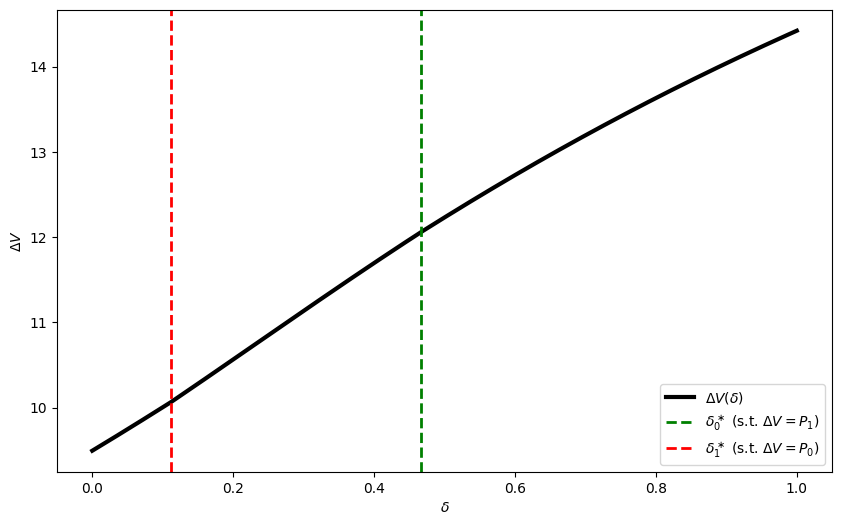

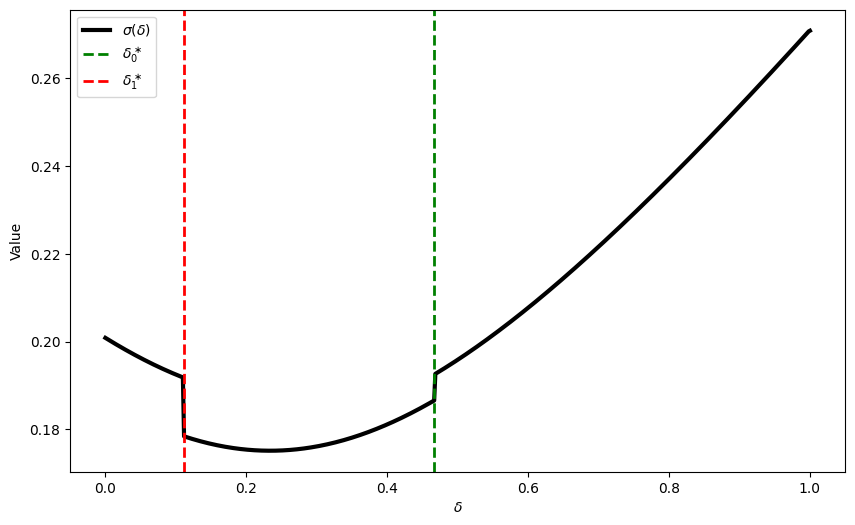

Minimum of 1/ΔV' at δ ≈ 0.23500000000000001


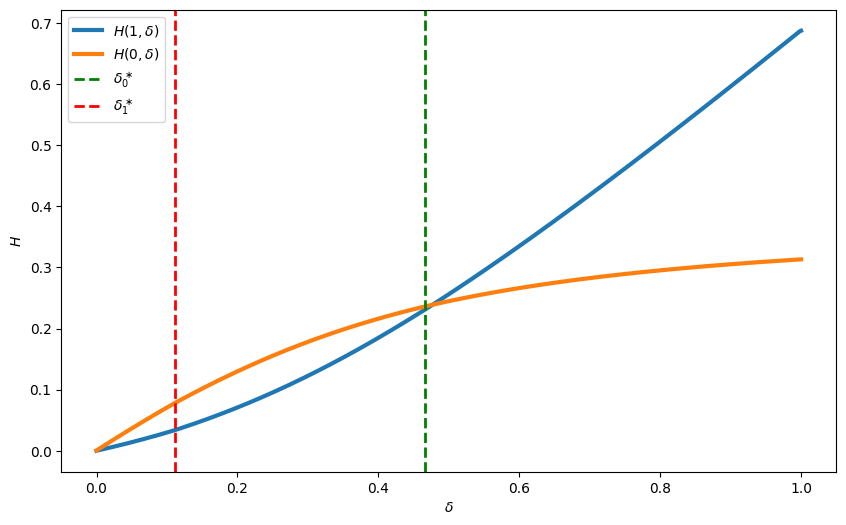

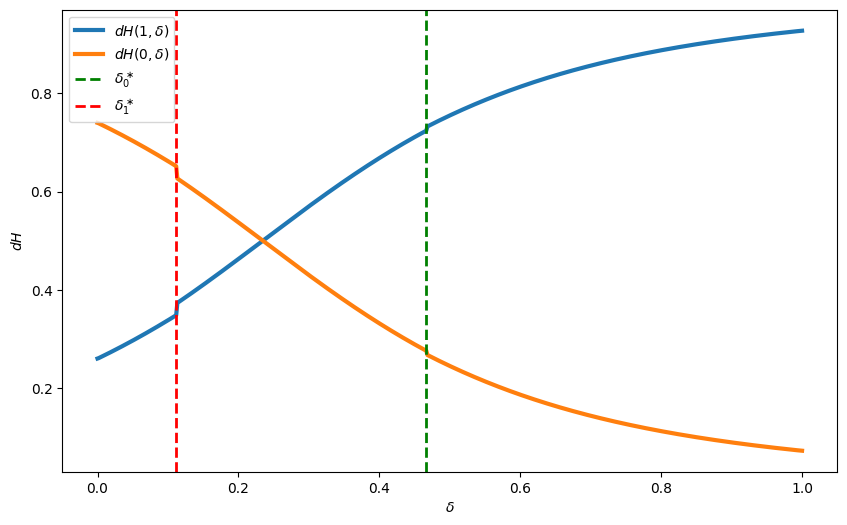

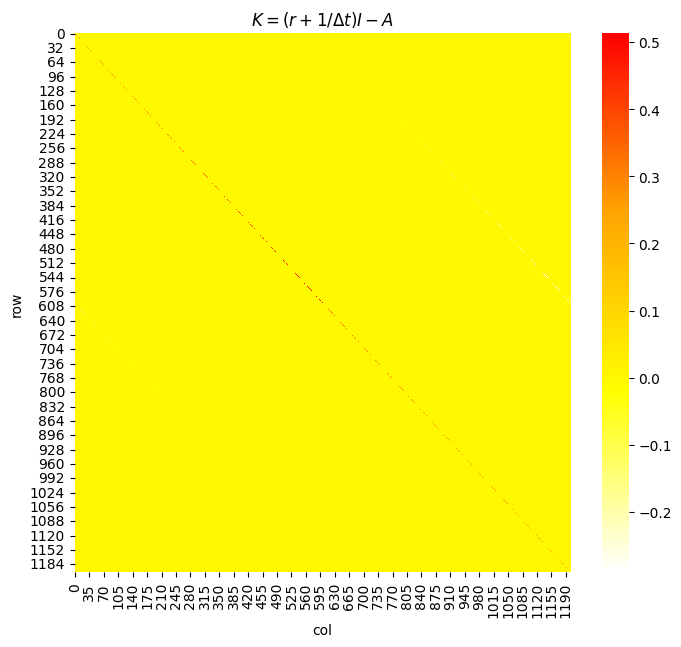

flippers rates 0,1: 0.30540020320801325 0.13525144743606834


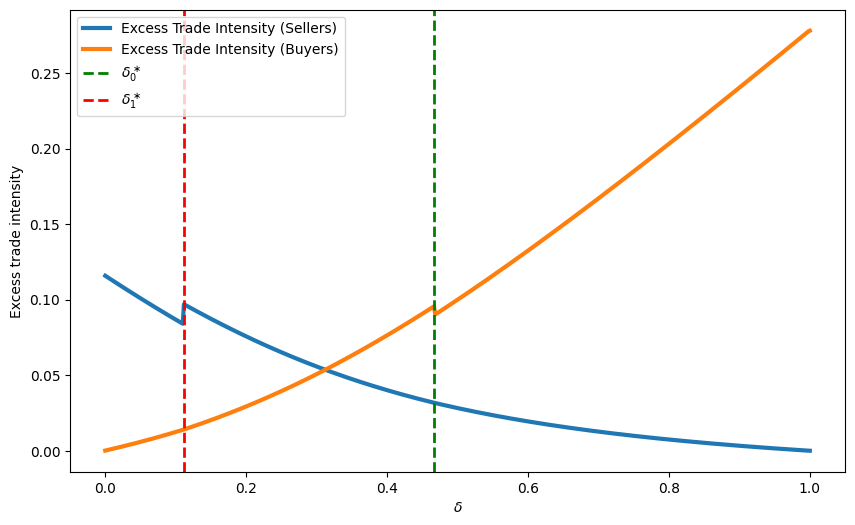

In [37]:
plot_all(out, params, grid, save_dir=None, hjb_dt_plot=10.0)


In [ ]:

# Constants
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
f,gamma,rho,lambda1,delta_0_star_initial, delta_1_star_initial=0.021,0.07,0.3,3,0.483672706,0.106481650304695

delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]

In [ ]:
# ===============================================================
#  CT model with quality: generator–adjoint solver + cutoff FOCs
# ===============================================================
# States: h ∈ {0,1} (nonowner/owner), type δ on a grid, quality q on a grid
# r V = b(δ,q) + A V,      stationary KFE: A^T H = 0
#
# - HJB via implicit backward-Euler (contractive) to tol
# - KFE via stationary linear solve (A^T H = 0, sum(H)=1)
# - HH–F acceptance by per-layer cutoffs δ1*(q) (owners sell to F),
#   δ0*(q) (nonowners buy from F)
# - HH–HH partner masses built by ΔV ordering within each q layer
# - Flipper 2×2 block per layer to get ΔW(q); global F split from totals
#
# Notes:
# - Depreciation α moves (δ_i, q_k) -> (δ_i, q_{k-1}) at rate α (reflect at k=0)
# - Utility flow for owners: u(δ,q) = δ * φ(q) − φ_H * q  (φ(q)=q^η by default)
# - Prices within layer: P0(q)=ΔV(δ1*(q), q), P1(q)=ΔV(δ0*(q), q)
#
# Author: CT cutoff policy iteration (fixed seller FOC sign)
# ===============================================================

from dataclasses import dataclass
import numpy as np

# -------------- Parameters -----------------

@dataclass
class Params:
    r: float
    gamma: float           # δ redraw
    rho: float             # HH–HH meeting
    lam: float             # HH–F meeting
    s: float               # owner share target (HH owners + F(1))
    f: float               # total flipper mass
    # quality
    q_min: float = 0.6
    q_max: float = 1.4
    alpha: float = 0.05    # depreciation rate k -> k-1
    eta: float = 1.0       # φ(q)=q^η
    phi_H: float = 0.0     # owner maintenance cost rate * q
    # (kept for future extensions)
    phi_F: float = 0.0

# -------------- Grids & utilities -----------

def make_grids(N_delta=121, N_q=41, q_min=0.6, q_max=1.4):
    δ = np.linspace(0.0, 1.0, N_delta)
    # trapezoid weights over δ, normalized to 1
    wδ = np.ones(N_delta) * (1.0/(N_delta-1))
    wδ[0] *= 0.5; wδ[-1] *= 0.5
    wδ = wδ / wδ.sum()
    q = np.linspace(q_min, q_max, N_q)
    return δ, wδ, q

def varphi(q, eta=1.0):
    return np.power(q, eta)

# flatten helpers (Fortran order: δ fast, q slow)
def flat(mat):
    return mat.flatten(order='F')

def unflat(vec, Nδ, Nq):
    return vec.reshape((Nδ, Nq), order='F')

def stacked(v0, v1):
    return np.concatenate([v0, v1], axis=0)

def unstack(v):
    N2 = v.size//2
    return v[:N2], v[N2:]

# -------------- HH–F acceptance (cutoffs) ----

def acceptance_from_cutoffs(δ, d0, d1):
    """
    Per layer k: owners sell to F if δ <= d1[k]
                 nonowners buy from F if δ >= d0[k]
    Returns two (Nδ,Nq) bool arrays.
    """
    Nδ, Nq = len(δ), len(d0)
    sell = np.zeros((Nδ, Nq), dtype=float)
    buy  = np.zeros((Nδ, Nq), dtype=float)
    for k in range(Nq):
        sell[:, k] = (δ <= d1[k]).astype(float)
        buy[:,  k] = (δ >= d0[k]).astype(float)
    return sell, buy

# -------------- Partner masses (per layer) ----

def partner_masses_layer(ΔV_k, H0tilde_k, H1tilde_k):
    """
    Given a single layer's ΔV (Nδ,), H0tilde (mass with weights), H1tilde,
    compute:
      M0_up[i]   = sum_{j: ΔV_j >= ΔV_i} H0tilde[j]
      M1_down[i] = sum_{j: ΔV_j <= ΔV_i} H1tilde[j]
      S0_up[i]   = sum_{j: ΔV_j >= ΔV_i} H0tilde[j]*ΔV_j
      S1_down[i] = sum_{j: ΔV_j <= ΔV_i} H1tilde[j]*ΔV_j
    """
    order = np.argsort(ΔV_k, kind='mergesort')   # ascending
    rank = np.empty_like(order)
    rank[order] = np.arange(order.size)

    H0o = H0tilde_k[order]; H1o = H1tilde_k[order]; DVo = ΔV_k[order]
    cH1   = np.cumsum(H1o)
    cH1DV = np.cumsum(H1o * DVo)
    cH0   = np.cumsum(H0o)
    cH0DV = np.cumsum(H0o * DVo)
    totH0, totH0DV = cH0[-1], cH0DV[-1]

    M1_down = cH1[rank]
    S1_down = cH1DV[rank]

    prefH0   = np.where(rank>0, cH0[rank-1], 0.0)
    prefH0DV = np.where(rank>0, cH0DV[rank-1], 0.0)
    M0_up = totH0   - prefH0
    S0_up = totH0DV - prefH0DV
    return M0_up, M1_down, S0_up, S1_down

# -------------- Build hazards -----------------

def build_hazards(params, sellF, buyF, M0_up, M1_down, F0, F1):
    lam, rho = params.lam, params.rho
    aF10 = lam * F0 * sellF
    aF01 = lam * F1 * buyF
    aHH10 = rho * M0_up
    aHH01 = rho * M1_down
    return aF10, aF01, aHH10, aHH01

# -------------- Assemble generator A & price flows φ ----

def assemble_A_and_phi(params, δ, wδ, q, sellF, buyF, H0tilde, H1tilde,
                       F0, F1, ΔV):
    """
    Build generator A and price-flow φ.

    A has blocks over h∈{0,1} and layers k=0..Nq-1.
    - Within each (h,k), redraw operator γ·(1 wδ^T) and outflows on diag.
    - Cross-block (same i,k): HH–F and HH–HH jumps 0<->1.
    - Quality depreciation α: (i,k)->(i,k-1) for k>0 (reflecting at k=0).

    φ = φ^HH + φ^F with midpoint pricing in HH–HH and ±P in HH–F.
    P0(k) = ΔV(δ1*(k), k),  P1(k) = ΔV(δ0*(k), k).
    """
    Nδ, Nq = len(δ), len(q)
    Nst = Nδ * Nq

    A  = np.zeros((2*Nst, 2*Nst))
    φ0 = np.zeros((Nδ, Nq))
    φ1 = np.zeros((Nδ, Nq))

    # --- per-layer HH–HH price flows (need partner masses)
    P0 = np.zeros(Nq); P1 = np.zeros(Nq)
    i0_arr = np.zeros(Nq, dtype=int)
    i1_arr = np.zeros(Nq, dtype=int)

    for k in range(Nq):
        H0t_k = H0tilde[:, k]
        H1t_k = H1tilde[:, k]
        H0_cdf = np.cumsum(H0t_k)
        H1_cdf = np.cumsum(H1t_k)

        ΔV_k = ΔV[:, k]
        M0_up, M1_down, S0_up, S1_down = partner_masses_layer(ΔV_k, H0t_k, H1t_k)

        # read cutoffs from masks: last True in sellF, first True in buyF
        idx1 = np.max(np.where(sellF[:, k] > 0)[0]) if np.any(sellF[:, k]) else 0
        idx0 = np.min(np.where(buyF[:,  k] > 0)[0]) if np.any(buyF[:,  k]) else Nδ-1
        i1_arr[k], i0_arr[k] = idx1, idx0
        P0[k] = float(ΔV_k[idx1])
        P1[k] = float(ΔV_k[idx0])

        # HH–HH midpoint price flows
        ρ = params.rho
        φ1[:, k] += 0.5 * ρ * (M0_up * ΔV_k + S0_up)         # owners receive
        φ0[:, k] += -0.5 * ρ * (M1_down * ΔV_k + S1_down)    # nonowners pay

    # --- hazards (full arrays)
    M0_full, M1_full = build_per_layer_M_arrays(ΔV, H0tilde, H1tilde)
    aF10, aF01, aHH10, aHH01 = build_hazards(params, sellF, buyF, M0_full, M1_full, F0, F1)

    # add HH–F price flows: owners +P0 when selling to F; nonowners −P1 when buying from F
    for k in range(Nq):
        φ1[:, k] += (aF10[:, k]) * P0[k]
        φ0[:, k] += -(aF01[:, k]) * P1[k]

    # --- assemble A (rows sum to zero)
    γ, α = params.gamma, params.alpha
    onesδ = np.ones(Nδ)
    Γ = γ * np.outer(onesδ, wδ)  # redraw inflow

    # outflow diagonals (no α yet)
    d0 = -(γ + aF01 + aHH01)   # for V0 rows
    d1 = -(γ + aF10 + aHH10)   # for V1 rows

    def add_block(block, h, k):
        row_off = (0 if h==0 else Nst) + k*Nδ
        col_off = (0 if h==0 else Nst) + k*Nδ
        A[row_off:row_off+Nδ, col_off:col_off+Nδ] += block

    # within-layer blocks + cross (0<->1) at same (i,k)
    for k in range(Nq):
        add_block(np.diag(d0[:, k]) + Γ, h=0, k=k)
        add_block(np.diag(d1[:, k]) + Γ, h=1, k=k)

        # into V0 from V1:
        A[k*Nδ:(k+1)*Nδ, Nst + k*Nδ : Nst + (k+1)*Nδ] += np.diag(aF01[:, k] + aHH01[:, k])
        # into V1 from V0:
        A[Nst + k*Nδ : Nst + (k+1)*Nδ, k*Nδ:(k+1)*Nδ] += np.diag(aF10[:, k] + aHH10[:, k])

    # quality depreciation α: (i,k)->(i,k-1), reflect at k=0
    if α > 0.0:
        for h in (0, 1):
            base = 0 if h==0 else Nst
            for k in range(Nq):
                rows = slice(base + k*Nδ, base + (k+1)*Nδ)
                if k > 0:
                    # outflow −α on diag of layer k
                    A[rows, rows] += -α * np.eye(Nδ)
                    # inflow +α from layer k to (k−1)
                    cols = slice(base + (k-1)*Nδ, base + k*Nδ)
                    A[rows, cols] += α * np.eye(Nδ)
                # if k==0: reflecting bottom — no α outflow, no inflow needed

    φ = stacked(flat(φ0), flat(φ1))
    aux = dict(P0=P0, P1=P1, i0=i0_arr, i1=i1_arr)
    return A, φ, aux


def build_per_layer_M_arrays(ΔV, H0tilde, H1tilde):
    """Return M0_up, M1_down arrays with shape (Nδ,Nq) to feed hazards."""
    Nδ, Nq = ΔV.shape
    M0 = np.zeros_like(ΔV)
    M1 = np.zeros_like(ΔV)
    for k in range(Nq):
        M0_up, M1_down, _, _ = partner_masses_layer(ΔV[:, k], H0tilde[:, k], H1tilde[:, k])
        M0[:, k] = M0_up
        M1[:, k] = M1_down
    return M0, M1

# -------------- HJB implicit & KFE stationary ----

def hjb_implicit(params, A, b, φ, V0_init, tol=1e-10, dt=10.0, max_steps=200):
    r = params.r
    K = (r + 1.0/dt) * np.eye(A.shape[0]) - A
    rhs = b + φ
    V = V0_init.copy()
    for _ in range(max_steps):
        V_next = np.linalg.solve(K, rhs + V/dt)
        if np.max(np.abs(V_next - V)) < tol:
            return V_next
        V = V_next
    return V

def kfe_stationary(A):
    """
    Solve A^T H = 0 with normalization sum(H)=1 by replacing one row.
    """
    AT = A.T.copy()
    n = AT.shape[0]
    b = np.zeros(n)
    # replace first row with ones for normalization
    AT[0, :] = 1.0
    b[0] = 1.0
    H = np.linalg.solve(AT, b)
    H = np.maximum(H, 0.0)
    s = H.sum()
    if s > 0:
        H /= s
    return H

# -------------- Flippers per layer, F split ----

def flipper_per_layer(params, δ, H0_cdf_layers, H1_cdf_layers, i0, i1, P0, P1):
    lam = params.lam
    Nq = len(P0)
    ΔW = np.zeros(Nq)
    q_b = np.zeros(Nq)
    q_s = np.zeros(Nq)
    for k in range(Nq):
        q_b[k] = lam * H1_cdf_layers[k][i1[k]]
        q_s[k] = lam * (H0_cdf_layers[k][-1] - H0_cdf_layers[k][i0[k]])
        # 2×2 flipper system in layer k
        r = params.r
        K = np.array([[r+q_b[k], -q_b[k]],
                      [-q_s[k],  r+q_s[k]]], dtype=float)
        rhs = np.array([-P0[k]*q_b[k], +P1[k]*q_s[k]], dtype=float)
        W0, W1 = np.linalg.solve(K, rhs)
        ΔW[k] = W1 - W0
    # global F split by total intensities
    qb_tot = q_b.sum(); qs_tot = q_s.sum()
    if qb_tot + qs_tot > 0:
        F1 = params.f * qb_tot / (qb_tot + qs_tot)
    else:
        F1 = 0.5 * params.f
    F0 = params.f - F1
    return ΔW, F0, F1, q_b, q_s

# -------------- Cutoff FOCs (correct signs) ----

def cutoff_focs_per_layer(δ, ΔV, H0tilde, H1tilde, wδ, ΔW):
    """
    Return updated (d0, d1) via bracketing/closest root of:
      R0(δ) = [H0(1)-H0(δ)] ΔV'(δ) - h0(δ) [ΔV(δ)-ΔW] = 0
      R1(δ) =  H1(δ)        ΔV'(δ) - h1(δ) [ΔW-ΔV(δ)] = 0
    """
    Nδ, Nq = ΔV.shape
    d0_new = np.zeros(Nq)
    d1_new = np.zeros(Nq)
    i0_new = np.zeros(Nq, dtype=int)
    i1_new = np.zeros(Nq, dtype=int)

    eps = 1e-14
    h0 = H0tilde / np.clip(wδ[:, None], eps, None)
    h1 = H1tilde / np.clip(wδ[:, None], eps, None)

    for k in range(Nq):
        ΔV_k = ΔV[:, k]
        H0_cdf = np.cumsum(H0tilde[:, k])
        H1_cdf = np.cumsum(H1tilde[:, k])
        DVp = np.gradient(ΔV_k, δ)
        # Correct seller FOC (fixed sign):
        R0 = (H0_cdf[-1] - H0_cdf) * DVp - h0[:, k] * (ΔV_k - ΔW[k])
        R1 = (H1_cdf) * DVp           - h1[:, k] * (ΔW[k] - ΔV_k)

        def root_from_resid(R):
            sgn = np.sign(R)
            idx = np.where(sgn[:-1]*sgn[1:] <= 0)[0]
            if idx.size > 0:
                j = int(idx[0])
                x0,x1 = δ[j], δ[j+1]
                y0,y1 = R[j], R[j+1]
                if abs(y1-y0) > 1e-14:
                    x = x0 - y0*(x1-x0)/(y1-y0)
                else:
                    x = 0.5*(x0+x1)
                x = float(np.clip(x, min(x0,x1), max(x0,x1)))
                i = int(np.argmin(np.abs(δ - x)))
                return x, i
            # fallback: closest to zero
            i = int(np.argmin(np.abs(R)))
            return float(δ[i]), i

        d0_new[k], i0_new[k] = root_from_resid(R0)
        d1_new[k], i1_new[k] = root_from_resid(R1)

    return d0_new, d1_new, i0_new, i1_new

# -------------- Sanity checks -----------------

def check_generator(A):
    rowsum = np.abs(A.sum(axis=1))
    offdiag = A.copy()
    np.fill_diagonal(offdiag, 0.0)
    return float(np.max(rowsum)), float(np.min(offdiag))

# -------------- Main solver -------------------

def solve_model_quality(params,
                        N_delta=121, N_q=41,
                        d0_init=0.50, d1_init=0.15,
                        max_outer=300,
                        cutoff_tol=1e-3,
                        hjb_dt=12.0, hjb_tol=1e-10, hjb_steps=200,
                        kfe_use_stationary=True,
                        verbose=True, chi=0.35, seed=0):
    rng = np.random.default_rng(seed)

    δ, wδ, q = make_grids(N_delta, N_q, params.q_min, params.q_max)
    Nδ, Nq = len(δ), len(q)
    Nst = Nδ*Nq

    # initial distributions: uniform over (δ,q), split half owners
    total_mass = 1.0
    H_layer_mass = total_mass / Nq
    H0tilde = np.tile((0.5 * wδ * H_layer_mass), (Nq,1)).T
    H1tilde = np.tile((0.5 * wδ * H_layer_mass), (Nq,1)).T

    # initial values
    V0 = np.zeros((Nδ, Nq))
    V1 = (δ[:, None] * varphi(q)[None, :]) / (params.r + params.gamma + 1e-9)
    V = stacked(flat(V0), flat(V1))
    ΔV = V1 - V0

    # cutoffs per layer (start ordered)
    d0 = np.full(Nq, float(d0_init))
    d1 = np.full(Nq, float(min(d1_init, d0_init)))
    # flipper split
    F0, F1 = 0.5*params.f, 0.5*params.f

    for it in range(max_outer):
        # acceptance masks
        sellF, buyF = acceptance_from_cutoffs(δ, d0, d1)

        # assemble A and φ with current objects
        b = np.zeros(2*Nst)
        # owner flow: u(δ,q)=δ φ(q) − φ_H q
        b[Nst:] = flat(δ[:, None]*varphi(q, params.eta)[None, :] - params.phi_H*q[None, :])

        A, φ, aux = assemble_A_and_phi(params, δ, wδ, q, sellF, buyF,
                                       H0tilde, H1tilde, F0, F1, ΔV)

        # sanity
        max_rowsum, min_offdiag = check_generator(A)
        if (it % 10)==0 and verbose:
            print(f"[A sanity] max|rowsum|={max_rowsum:.2e}  min(offdiag)={min_offdiag:.2e}")

        # HJB implicit
        V_old = V.copy()
        V = hjb_implicit(params, A, b, φ, V, tol=hjb_tol, dt=hjb_dt, max_steps=hjb_steps)
        V0_vec, V1_vec = unstack(V)
        V0 = unflat(V0_vec, Nδ, Nq)
        V1 = unflat(V1_vec, Nδ, Nq)
        ΔV = V1 - V0
        bell = float(np.max(np.abs(V - V_old)))

        # update prices from new ΔV (per layer)
        P0, P1, i0, i1 = aux['P0'].copy(), aux['P1'].copy(), aux['i0'], aux['i1']
        for k in range(Nq):
            P0[k] = float(ΔV[i1[k], k])
            P1[k] = float(ΔV[i0[k], k])

        # KFE stationary (for current A)
        H_vec_old = stacked(flat(H0tilde), flat(H1tilde))
        if kfe_use_stationary:
            H_vec = kfe_stationary(A)
        else:
            # fallback: one implicit step (rarely needed)
            K = np.eye(2*Nst) - (1.0/hjb_dt) * A.T
            H_vec = np.linalg.solve(K, H_vec_old)
            H_vec = np.maximum(H_vec, 0.0)
            s = H_vec.sum()
            if s>0: H_vec /= s
        kfe_err = float(np.linalg.norm(H_vec - H_vec_old, 1))
        H0tilde = unflat(H_vec[:Nst], Nδ, Nq)
        H1tilde = unflat(H_vec[Nst:], Nδ, Nq)

        # flippers per layer (ΔW_k) and F split
        # build CDFs on updated H
        H0_cdfs = [np.cumsum(H0tilde[:, k]) for k in range(Nq)]
        H1_cdfs = [np.cumsum(H1tilde[:, k]) for k in range(Nq)]
        ΔW_k, F0, F1, qb, qs = flipper_per_layer(params, δ, H0_cdfs, H1_cdfs, i0, i1, P0, P1)

        # enforce owner share: sum(H1)+F1 = s
        target_H1_mass = max(1e-12, params.s - F1)
        cur_H1_mass = float(H1tilde.sum())
        cur_H0_mass = float(H0tilde.sum())
        if cur_H1_mass > 0:
            H1tilde *= target_H1_mass / cur_H1_mass
        if cur_H0_mass > 0:
            H0tilde *= (1.0 - target_H1_mass) / cur_H0_mass

        # cutoff updates via FOCs (correct residuals)
        d0_new, d1_new, i0_new, i1_new = cutoff_focs_per_layer(δ, ΔV, H0tilde, H1tilde, wδ, ΔW_k)

        # damping + order
        d0 = (1.0 - chi) * d0 + chi * d0_new
        d1 = (1.0 - chi) * d1 + chi * d1_new
        # enforce δ1*(q) ≤ δ0*(q)
        mid = 0.5*(d0 + d1)
        swap = d1 > d0
        if np.any(swap):
            d0[swap] = np.maximum(mid[swap], d0[swap])
            d1[swap] = np.minimum(mid[swap], d1[swap])

        cutdiff = float(max(np.max(np.abs(d0_new - d0)), np.max(np.abs(d1_new - d1))))

        if verbose:
            print(f"[it {it:03d}] |Bell|={bell:.2e}  |KFE|={kfe_err:.2e}  |Δδ|={cutdiff:.2e}  "
                  f"F1={F1:.5f}  d0̄={np.mean(d0):.3f} d1̄={np.mean(d1):.3f}")

        if max(bell, kfe_err, cutdiff) < cutoff_tol:
            print(f"Converged in {it} iters with |Δ|={max(bell,kfe_err,cutdiff):.2e}")
            break

    return dict(
        delta=δ, wδ=wδ, q=q,
        V0=V0, V1=V1, ΔV=ΔV,
        H0tilde=H0tilde, H1tilde=H1tilde,
        d0_star=d0, d1_star=d1,
        P0=P0, P1=P1,
        F0=F0, F1=F1,
        A=A, b=b
    )

# ----------------- Example run -----------------

if __name__ == "__main__":
    # Baseline-ish parameters (tweak freely)
    params = Params(
        r=0.0361577940, gamma=0.0867540457, rho=0.25, lam=3.5,
        s=0.70, f=0.01, q_min=0.6, q_max=1.4, alpha=0.05,
        eta=1.0, phi_H=0.00, phi_F=0.0
    )

    out = solve_model_quality(
        params,
        N_delta=51, N_q=21,
        d0_init=0.48, d1_init=0.11,
        max_outer=500,
        cutoff_tol=1e-4,   # you can tighten to 1e-5/1e-6 later
        hjb_dt=12.0, hjb_tol=1e-10, hjb_steps=300,
        kfe_use_stationary=True,
        verbose=True, chi=0.35, seed=0
    )

    print("\n--- Final summary ---")
    print("mean δ0*(q):", float(np.mean(out['d0_star'])))
    print("mean δ1*(q):", float(np.mean(out['d1_star'])))
    print("F split     :", float(out['F0']), float(out['F1']))
    print("Mass check  :", float((out['H0tilde']+out['H1tilde']).sum()))


[A sanity] max|rowsum|=1.09e-16  min(offdiag)=0.00e+00
[it 000] |Bell|=1.22e+01  |KFE|=1.90e+00  |Δδ|=3.05e-01  F1=0.00326  d0̄=0.323 d1̄=0.076
[it 001] |Bell|=3.06e+00  |KFE|=1.89e-01  |Δδ|=1.99e-01  F1=0.00284  d0̄=0.221 d1̄=0.054
[it 002] |Bell|=6.40e-01  |KFE|=3.54e-02  |Δδ|=1.29e-01  F1=0.00269  d0̄=0.154 d1̄=0.040
[it 003] |Bell|=1.64e-01  |KFE|=6.38e-03  |Δδ|=8.39e-02  F1=0.00264  d0̄=0.112 d1̄=0.031
[it 004] |Bell|=1.25e-01  |KFE|=1.84e-03  |Δδ|=5.45e-02  F1=0.00276  d0̄=0.084 d1̄=0.025
[it 005] |Bell|=1.11e-01  |KFE|=3.68e-03  |Δδ|=3.54e-02  F1=0.00322  d0̄=0.066 d1̄=0.022
[it 006] |Bell|=2.67e-01  |KFE|=2.63e-03  |Δδ|=2.30e-02  F1=0.00340  d0̄=0.054 d1̄=0.019
[it 007] |Bell|=1.64e-01  |KFE|=8.21e-04  |Δδ|=1.50e-02  F1=0.00342  d0̄=0.047 d1̄=0.018
[it 008] |Bell|=3.69e-02  |KFE|=1.37e-03  |Δδ|=9.73e-03  F1=0.00342  d0̄=0.042 d1̄=0.016
[it 009] |Bell|=6.31e-02  |KFE|=1.59e-03  |Δδ|=6.33e-03  F1=0.00343  d0̄=0.039 d1̄=0.016
[A sanity] max|rowsum|=9.71e-17  min(offdiag)=0.00e+00


KeyboardInterrupt: 

In [8]:
# === unchanged imports & dataclasses ===
from dataclasses import dataclass
import numpy as np

@dataclass
class Params:
    r: float
    gamma: float
    rho: float
    lam: float
    s: float
    f: float
    q_min: float = 0.6
    q_max: float = 1.4
    alpha: float = 0.05
    eta: float = 1.0
    phi_H: float = 0.0
    phi_F: float = 0.0

# ---------- grids & helpers ----------
def make_grids(N_delta=121, N_q=41, q_min=0.6, q_max=1.4):
    δ = np.linspace(0.0, 1.0, N_delta)
    wδ = np.ones(N_delta) * (1.0/(N_delta-1))
    wδ[0] *= 0.5; wδ[-1] *= 0.5
    wδ = wδ / wδ.sum()
    q = np.linspace(q_min, q_max, N_q)
    return δ, wδ, q

def varphi(q, eta=1.0): return np.power(q, eta)
def flat(M): return M.flatten(order='F')
def unflat(v, Nδ, Nq): return v.reshape((Nδ, Nq), order='F')
def stacked(v0, v1): return np.concatenate([v0, v1], axis=0)
def unstack(v): N2=v.size//2; return v[:N2], v[N2:]

# ---------- acceptances, partner masses ----------
def acceptance_from_cutoffs(δ, d0, d1):
    Nδ, Nq = len(δ), len(d0)
    sell = np.zeros((Nδ, Nq), dtype=float)
    buy  = np.zeros((Nδ, Nq), dtype=float)
    for k in range(Nq):
        sell[:, k] = (δ <= d1[k]).astype(float)
        buy[:,  k] = (δ >= d0[k]).astype(float)
    return sell, buy

def partner_masses_layer(ΔV_k, H0tilde_k, H1tilde_k):
    order = np.argsort(ΔV_k, kind='mergesort')
    rank = np.empty_like(order); rank[order] = np.arange(order.size)
    H0o, H1o, DVo = H0tilde_k[order], H1tilde_k[order], ΔV_k[order]
    cH1   = np.cumsum(H1o);  cH1DV = np.cumsum(H1o*DVo)
    cH0   = np.cumsum(H0o);  cH0DV = np.cumsum(H0o*DVo)
    totH0, totH0DV = cH0[-1], cH0DV[-1]
    M1_down = cH1[rank]; S1_down = cH1DV[rank]
    prefH0   = np.where(rank>0, cH0[rank-1], 0.0)
    prefH0DV = np.where(rank>0, cH0DV[rank-1], 0.0)
    M0_up = totH0 - prefH0
    S0_up = totH0DV - prefH0DV
    return M0_up, M1_down, S0_up, S1_down

def build_per_layer_M_arrays(ΔV, H0tilde, H1tilde):
    Nδ, Nq = ΔV.shape
    M0 = np.zeros_like(ΔV); M1 = np.zeros_like(ΔV)
    for k in range(Nq):
        M0_up, M1_down, _, _ = partner_masses_layer(ΔV[:, k], H0tilde[:, k], H1tilde[:, k])
        M0[:, k] = M0_up; M1[:, k] = M1_down
    return M0, M1

def build_hazards(params, sellF, buyF, M0_up, M1_down, F0, F1):
    lam, rho = params.lam, params.rho
    aF10 = lam * F0 * sellF
    aF01 = lam * F1 * buyF
    aHH10 = rho * M0_up
    aHH01 = rho * M1_down
    return aF10, aF01, aHH10, aHH01

# ---------- assemble A and price flows (with optional frozen M) ----------
def assemble_A_and_phi(params, δ, wδ, q, sellF, buyF, H0tilde, H1tilde,
                       F0, F1, ΔV, M0_full=None, M1_full=None):
    Nδ, Nq = len(δ), len(q); Nst = Nδ*Nq
    A  = np.zeros((2*Nst, 2*Nst))
    φ0 = np.zeros((Nδ, Nq)); φ1 = np.zeros((Nδ, Nq))
    P0 = np.zeros(Nq); P1 = np.zeros(Nq)
    i0_arr = np.zeros(Nq, dtype=int); i1_arr = np.zeros(Nq, dtype=int)

    # price flows from HH–HH (midpoint)
    for k in range(Nq):
        H0t_k, H1t_k = H0tilde[:, k], H1tilde[:, k]
        ΔV_k = ΔV[:, k]
        M0_up, M1_down, S0_up, S1_down = partner_masses_layer(ΔV_k, H0t_k, H1t_k)
        # get cutoffs from masks
        idx1 = np.max(np.where(sellF[:, k] > 0)[0]) if np.any(sellF[:, k]) else 0
        idx0 = np.min(np.where(buyF[:,  k] > 0)[0]) if np.any(buyF[:,  k]) else Nδ-1
        i1_arr[k], i0_arr[k] = idx1, idx0
        P0[k], P1[k] = float(ΔV_k[idx1]), float(ΔV_k[idx0])
        ρ = params.rho
        φ1[:, k] += 0.5 * ρ * (M0_up * ΔV_k + S0_up)
        φ0[:, k] += -0.5 * ρ * (M1_down * ΔV_k + S1_down)

    # hazards (use frozen M if provided)
    if (M0_full is None) or (M1_full is None):
        M0_full, M1_full = build_per_layer_M_arrays(ΔV, H0tilde, H1tilde)
    aF10, aF01, aHH10, aHH01 = build_hazards(params, sellF, buyF, M0_full, M1_full, F0, F1)

    # add HH–F price flows
    for k in range(Nq):
        φ1[:, k] += aF10[:, k] * P0[k]
        φ0[:, k] += -aF01[:, k] * P1[k]

    # assemble generator A
    γ, α = params.gamma, params.alpha
    onesδ = np.ones(Nδ)
    Γ = γ * np.outer(onesδ, wδ)
    d0 = -(γ + aF01 + aHH01)
    d1 = -(γ + aF10 + aHH10)

    def add_block(block, h, k):
        r0 = (0 if h==0 else Nst) + k*Nδ
        c0 = r0
        A[r0:r0+Nδ, c0:c0+Nδ] += block

    for k in range(Nq):
        add_block(np.diag(d0[:, k]) + Γ, h=0, k=k)
        add_block(np.diag(d1[:, k]) + Γ, h=1, k=k)
        # cross 0<->1
        A[k*Nδ:(k+1)*Nδ, Nst + k*Nδ : Nst + (k+1)*Nδ] += np.diag(aF01[:, k] + aHH01[:, k])
        A[Nst + k*Nδ : Nst + (k+1)*Nδ, k*Nδ:(k+1)*Nδ] += np.diag(aF10[:, k] + aHH10[:, k])

    # quality depreciation α: (i,k)->(i,k-1), reflect at k=0
    if α > 0.0:
        for h in (0,1):
            base = 0 if h==0 else Nst
            for k in range(Nq):
                rows = slice(base + k*Nδ, base + (k+1)*Nδ)
                if k>0:
                    A[rows, rows] += -α * np.eye(Nδ)            # outflow
                    A[rows, slice(base + (k-1)*Nδ, base + k*Nδ)] += α * np.eye(Nδ)  # inflow

    φ = stacked(flat(φ0), flat(φ1))
    aux = dict(P0=P0, P1=P1, i0=i0_arr, i1=i1_arr, M0=M0_full, M1=M1_full)
    return A, φ, aux

# ---------- HJB implicit, KFE stationary with residual ----------
def hjb_implicit(params, A, b, φ, V0_init, tol=1e-10, dt=10.0, max_steps=200):
    r = params.r
    K = (r + 1.0/dt) * np.eye(A.shape[0]) - A
    rhs = b + φ
    V = V0_init.copy()
    for _ in range(max_steps):
        Vn = np.linalg.solve(K, rhs + V/dt)
        if np.max(np.abs(Vn - V)) < tol:
            return Vn
        V = Vn
    return V

def kfe_stationary(A):
    AT = A.T.copy()
    n = AT.shape[0]
    rhs = np.zeros(n)
    AT[0, :] = 1.0     # normalization row
    rhs[0] = 1.0
    H = np.linalg.solve(AT, rhs)
    H = np.maximum(H, 0.0)
    s = H.sum()
    if s>0: H /= s
    # proper residual:
    res = float(np.linalg.norm(A.T @ H, 1))
    return H, res

# ---------- flippers & cutoff FOCs ----------
def flipper_per_layer(params, δ, H0_cdfs, H1_cdfs, i0, i1, P0, P1):
    lam = params.lam; r = params.r; Nq = len(P0)
    ΔW = np.zeros(Nq); q_b = np.zeros(Nq); q_s = np.zeros(Nq)
    for k in range(Nq):
        q_b[k] = lam * H1_cdfs[k][i1[k]]
        q_s[k] = lam * (H0_cdfs[k][-1] - H0_cdfs[k][i0[k]])
        K = np.array([[r+q_b[k], -q_b[k]], [-q_s[k], r+q_s[k]]], float)
        rhs = np.array([-P0[k]*q_b[k], +P1[k]*q_s[k]], float)
        W0, W1 = np.linalg.solve(K, rhs); ΔW[k] = W1 - W0
    qb_tot, qs_tot = q_b.sum(), q_s.sum()
    F1 = params.f * qb_tot/(qb_tot+qs_tot) if (qb_tot+qs_tot)>0 else 0.5*params.f
    F0 = params.f - F1
    return ΔW, F0, F1, q_b, q_s

def cutoff_focs_per_layer(δ, ΔV, H0tilde, H1tilde, wδ, ΔW):
    Nδ, Nq = ΔV.shape
    d0_new = np.zeros(Nq); d1_new = np.zeros(Nq)
    i0_new = np.zeros(Nq, int); i1_new = np.zeros(Nq, int)
    eps = 1e-14
    h0 = H0tilde/np.clip(wδ[:, None], eps, None)
    h1 = H1tilde/np.clip(wδ[:, None], eps, None)
    for k in range(Nq):
        ΔV_k = ΔV[:, k]; DVp = np.gradient(ΔV_k, δ)
        H0_cdf = np.cumsum(H0tilde[:, k]); H1_cdf = np.cumsum(H1tilde[:, k])
        R0 = (H0_cdf[-1]-H0_cdf)*DVp - h0[:,k]*(ΔV_k - ΔW[k])    # seller FOC
        R1 = (H1_cdf)*DVp        - h1[:,k]*(ΔW[k] - ΔV_k)        # buyer FOC
        def root_from(R):
            s = np.sign(R); idx = np.where(s[:-1]*s[1:]<=0)[0]
            if idx.size>0:
                j=int(idx[0]); x0,x1=δ[j],δ[j+1]; y0,y1=R[j],R[j+1]
                x = x0 - y0*(x1-x0)/(y1-y0) if abs(y1-y0)>1e-14 else 0.5*(x0+x1)
                x = float(np.clip(x, min(x0,x1), max(x0,x1)))
                i = int(np.argmin(np.abs(δ-x))); return x,i
            i = int(np.argmin(np.abs(R))); return float(δ[i]), i
        d0_new[k], i0_new[k] = root_from(R0)
        d1_new[k], i1_new[k] = root_from(R1)
    return d0_new, d1_new, i0_new, i1_new

# ---------- generator sanity ----------
def check_generator(A):
    rowsum = np.abs(A.sum(axis=1))
    offd = A.copy(); np.fill_diagonal(offd, 0.0)
    return float(np.max(rowsum)), float(np.min(offd))

# ---------- NEW: calibrate F1 so A^T H = 0 and sum(H1)+F1 = s ----------
def calibrate_F1_to_owner_share(params, δ, wδ, q, sellF, buyF,
                                H0tilde, H1tilde, ΔV, M0_full, M1_full,
                                s_target, f_total, tol=1e-8, max_it=30):
    Nδ, Nq = len(δ), len(q); Nst = Nδ*Nq

    def eval_at(F1_):
        F1_ = float(np.clip(F1_, 0.0, f_total)); F0_ = f_total - F1_
        A_, φ_, _ = assemble_A_and_phi(params, δ, wδ, q, sellF, buyF,
                                       H0tilde, H1tilde, F0_, F1_, ΔV,
                                       M0_full, M1_full)
        H_, res_ = kfe_stationary(A_)
        H1_mass = float(H_[Nst:].sum())
        g = H1_mass + F1_ - s_target
        return g, H_, res_, F0_, F1_

    # bracket on [0,f]
    g0, H0v, res0, F00, F10 = eval_at(0.0)
    g1, H1v, res1, F01, F11 = eval_at(f_total)

    # If no sign change, clamp to closer bound
    if g0*g1 > 0:
        if abs(g0) <= abs(g1):
            return H0v, res0, F00, F10
        else:
            return H1v, res1, F01, F11

    lo, hi = 0.0, f_total; Hbest=None; resbest=np.inf; F0best=F00; F1best=F10
    for _ in range(max_it):
        mid = 0.5*(lo+hi)
        gm, Hm, resm, F0m, F1m = eval_at(mid)
        if abs(gm) < tol:
            return Hm, resm, F0m, F1m
        if g0*gm <= 0:
            hi = mid
            Hbest, resbest, F0best, F1best = Hm, resm, F0m, F1m
            g1 = gm
        else:
            lo = mid
            g0 = gm
    # fallback last best
    if Hbest is None: Hbest, resbest, F0best, F1best = Hm, resm, F0m, F1m
    return Hbest, resbest, F0best, F1best

# ---------- main solver (with KFE fix) ----------
def solve_model_quality(params,
                        N_delta=121, N_q=41,
                        d0_init=0.50, d1_init=0.15,
                        max_outer=300,
                        cutoff_tol=1e-4,
                        hjb_dt=12.0, hjb_tol=1e-10, hjb_steps=300,
                        kfe_use_stationary=True,  # kept for API; we now always do stationary
                        verbose=True, chi=0.35, seed=0):
    rng = np.random.default_rng(seed)
    δ, wδ, q = make_grids(N_delta, N_q, params.q_min, params.q_max)
    Nδ, Nq = len(δ), len(q); Nst = Nδ*Nq

    # initial H (uniform across layers, half owners)
    H_layer_mass = 1.0 / Nq
    H0tilde = np.tile((0.5 * wδ * H_layer_mass), (Nq,1)).T
    H1tilde = np.tile((0.5 * wδ * H_layer_mass), (Nq,1)).T

    # initial V
    V0 = np.zeros((Nδ, Nq))
    V1 = (δ[:, None] * varphi(q, params.eta)[None, :] - params.phi_H*q[None, :]) / (params.r + params.gamma + 1e-9)
    V = stacked(flat(V0), flat(V1))
    ΔV = V1 - V0

    # initial cutoffs and F split
    d0 = np.full(Nq, float(d0_init))
    d1 = np.full(Nq, float(min(d1_init, d0_init)))
    F0, F1 = 0.5*params.f, 0.5*params.f

    for it in range(max_outer):
        sellF, buyF = acceptance_from_cutoffs(δ, d0, d1)

        # freeze partner masses with current ΔV and H for this outer step
        M0_full, M1_full = build_per_layer_M_arrays(ΔV, H0tilde, H1tilde)

        # Assemble A, φ with current F-split (for HJB step)
        b = np.zeros(2*Nst)
        b[Nst:] = flat(δ[:, None]*varphi(q, params.eta)[None, :] - params.phi_H*q[None, :])
        A, φ, aux = assemble_A_and_phi(params, δ, wδ, q, sellF, buyF,
                                       H0tilde, H1tilde, F0, F1, ΔV,
                                       M0_full, M1_full)

        if (it % 10) == 0 and verbose:
            max_rowsum, min_offdiag = check_generator(A)
            print(f"[A sanity] max|rowsum|={max_rowsum:.2e}  min(offdiag)={min_offdiag:.2e}")

        # HJB implicit -> update V and ΔV
        V_old = V.copy()
        V = hjb_implicit(params, A, b, φ, V, tol=hjb_tol, dt=hjb_dt, max_steps=hjb_steps)
        V0v, V1v = unstack(V)
        V0 = unflat(V0v, Nδ, Nq); V1 = unflat(V1v, Nδ, Nq); ΔV = V1 - V0
        bell = float(np.max(np.abs(V - V_old)))

        # refresh layer prices from updated ΔV
        P0, P1, i0, i1 = aux['P0'].copy(), aux['P1'].copy(), aux['i0'], aux['i1']
        for k in range(Nq):
            P0[k] = float(ΔV[i1[k], k]); P1[k] = float(ΔV[i0[k], k])

        # ===== Stationary KFE with calibrated F1 to hit s exactly =====
        H_vec, kfe_res, F0, F1 = calibrate_F1_to_owner_share(
            params, δ, wδ, q, sellF, buyF, H0tilde, H1tilde, ΔV,
            M0_full, M1_full, s_target=params.s, f_total=params.f,
            tol=1e-10, max_it=40
        )
        H0tilde = unflat(H_vec[:Nst], Nδ, Nq)
        H1tilde = unflat(H_vec[Nst:], Nδ, Nq)

        # per-layer CDFs and flipper ΔW(q)
        H0_cdfs = [np.cumsum(H0tilde[:, k]) for k in range(Nq)]
        H1_cdfs = [np.cumsum(H1tilde[:, k]) for k in range(Nq)]
        ΔW_k, _, _, _, _ = flipper_per_layer(params, δ, H0_cdfs, H1_cdfs, i0, i1, P0, P1)

        # cutoff updates via FOCs
        d0_new, d1_new, _, _ = cutoff_focs_per_layer(δ, ΔV, H0tilde, H1tilde, wδ, ΔW_k)
        d0 = (1.0-chi)*d0 + chi*d0_new
        d1 = (1.0-chi)*d1 + chi*d1_new
        # enforce order
        mid = 0.5*(d0+d1); swap = d1>d0
        if np.any(swap):
            d0[swap] = np.maximum(mid[swap], d0[swap]); d1[swap] = np.minimum(mid[swap], d1[swap])

        cutdiff = float(max(np.max(np.abs(d0_new - d0)), np.max(np.abs(d1_new - d1))))

        if verbose:
            print(f"[it {it:03d}] |Bell|={bell:.2e}  |KFE(res)|={kfe_res:.2e}  |Δδ|={cutdiff:.2e}  "
                  f"F1={F1:.5f}  d0̄={np.mean(d0):.3f} d1̄={np.mean(d1):.3f}")

        if max(bell, kfe_res, cutdiff) < cutoff_tol:
            print(f"Converged in {it} iters with max residual {max(bell,kfe_res,cutdiff):.2e}")
            break

    return dict(delta=δ, wδ=wδ, q=q,
                V0=V0, V1=V1, ΔV=ΔV,
                H0tilde=H0tilde, H1tilde=H1tilde,
                d0_star=d0, d1_star=d1,
                P0=P0, P1=P1, F0=F0, F1=F1,
                A=A, b=b)

# ----------------- Example run -----------------

if __name__ == "__main__":
    # Baseline-ish parameters (tweak freely)
    params = Params(
        r=0.0361577940, gamma=0.0867540457, rho=0.25, lam=3.5,
        s=0.70, f=0.04, q_min=1.0, q_max=2.0, alpha=0.03,
        eta=1.0, phi_H=0.08, phi_F=0.03
    )

    out = solve_model_quality(
        params,
        N_delta=51, N_q=21,
        d0_init=0.48, d1_init=0.31,
        max_outer=500,
        cutoff_tol=1e-4,   # you can tighten to 1e-5/1e-6 later
        hjb_dt=12.0, hjb_tol=1e-10, hjb_steps=300,
        kfe_use_stationary=True,
        verbose=True, chi=0.35, seed=0
    )

    print("\n--- Final summary ---")
    print("mean δ0*(q):", float(np.mean(out['d0_star'])))
    print("mean δ1*(q):", float(np.mean(out['d1_star'])))
    print("F split     :", float(out['F0']), float(out['F1']))
    print("Mass check  :", float((out['H0tilde']+out['H1tilde']).sum()))


[A sanity] max|rowsum|=1.11e-16  min(offdiag)=0.00e+00
[it 000] |Bell|=1.41e+01  |KFE(res)|=3.71e-17  |Δδ|=3.05e-01  F1=0.02512  d0̄=0.323 d1̄=0.208
[it 001] |Bell|=4.32e+00  |KFE(res)|=3.12e-17  |Δδ|=1.99e-01  F1=0.02347  d0̄=0.220 d1̄=0.141
[it 002] |Bell|=1.71e+00  |KFE(res)|=3.82e-17  |Δδ|=1.29e-01  F1=0.01974  d0̄=0.154 d1̄=0.098
[it 003] |Bell|=5.57e-01  |KFE(res)|=3.68e-17  |Δδ|=8.39e-02  F1=0.01790  d0̄=0.110 d1̄=0.069
[it 004] |Bell|=4.31e-01  |KFE(res)|=4.50e-17  |Δδ|=5.45e-02  F1=0.01568  d0̄=0.082 d1̄=0.051
[it 005] |Bell|=3.88e-01  |KFE(res)|=2.81e-17  |Δδ|=3.54e-02  F1=0.01404  d0̄=0.063 d1̄=0.039
[it 006] |Bell|=3.93e-01  |KFE(res)|=3.32e-17  |Δδ|=2.30e-02  F1=0.01244  d0̄=0.052 d1̄=0.031
[it 007] |Bell|=4.63e-01  |KFE(res)|=3.08e-17  |Δδ|=4.19e-02  F1=0.01238  d0̄=0.045 d1̄=0.025
[it 008] |Bell|=1.86e-01  |KFE(res)|=2.91e-17  |Δδ|=9.73e-03  F1=0.01293  d0̄=0.040 d1̄=0.022
[it 009] |Bell|=3.17e-01  |KFE(res)|=3.49e-17  |Δδ|=2.93e-02  F1=0.01139  d0̄=0.037 d1̄=0.020
[A sa

KeyboardInterrupt: 

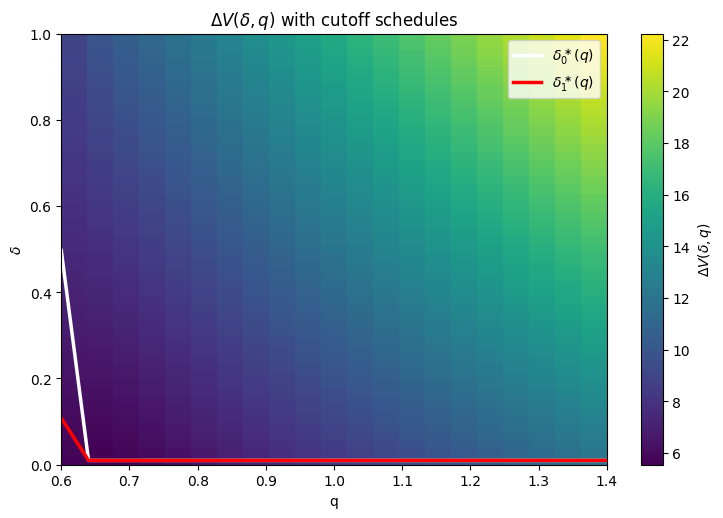

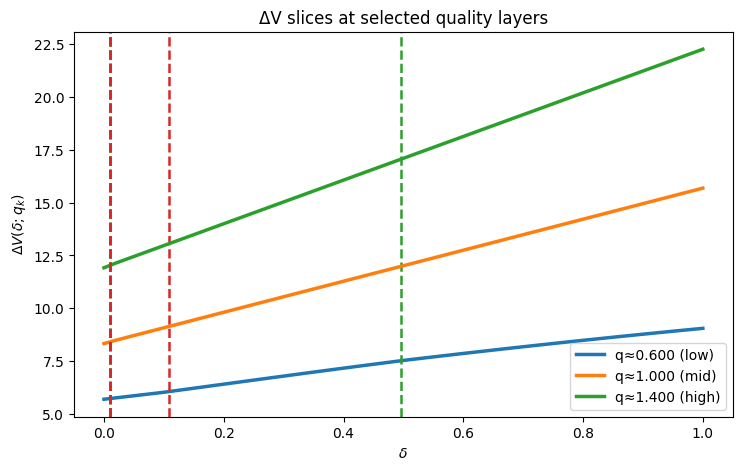

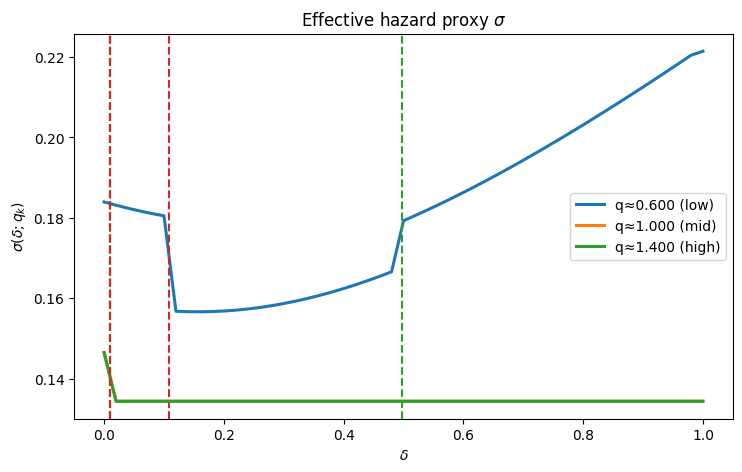

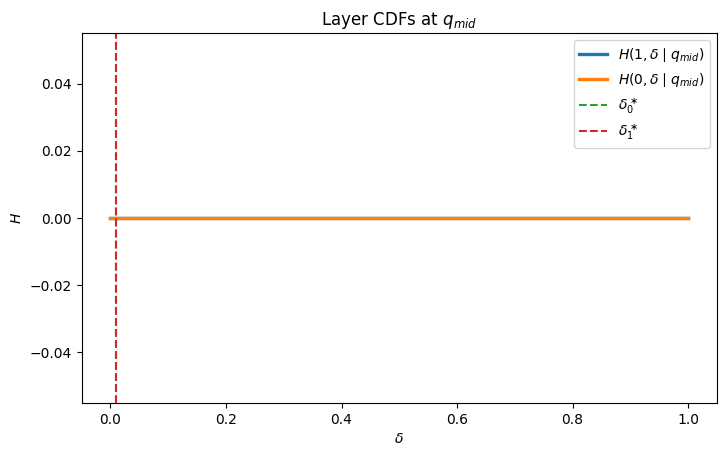

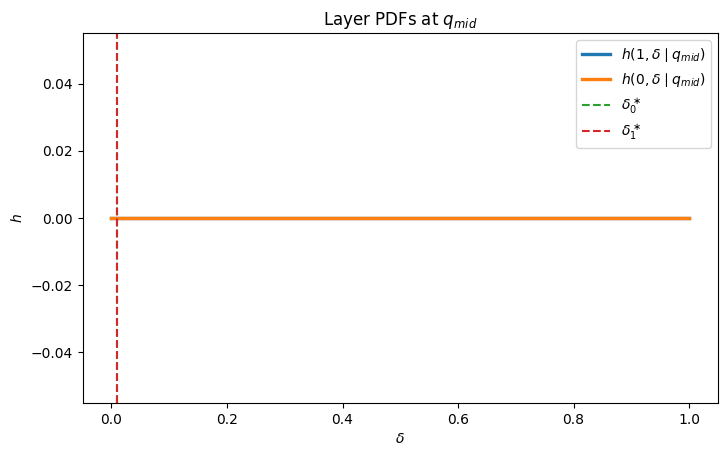

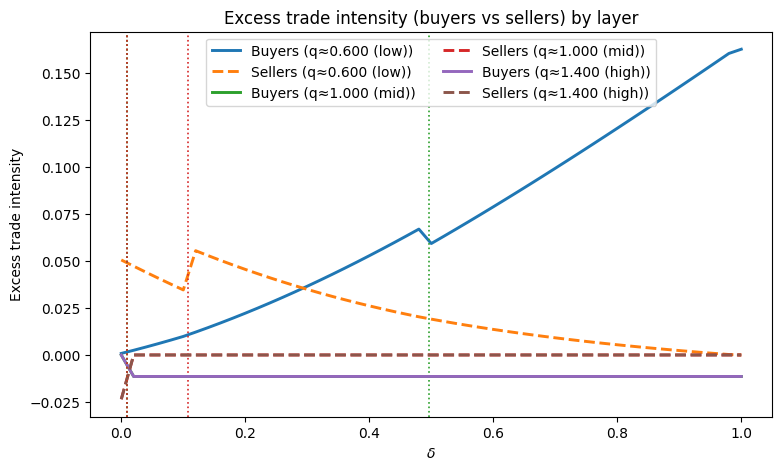

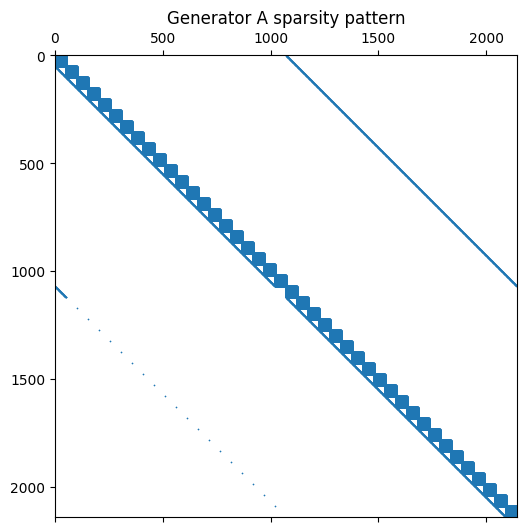

In [5]:
# ============================================================
# Plotting for the CT generator–adjoint solver WITH QUALITY q
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# ---------- helpers ----------
def _cdf_from_mass_layerwise(Htilde):
    return np.cumsum(Htilde, axis=0)

def _pdf_from_mass_layerwise(Htilde, wδ):
    eps = 1e-14
    return Htilde / np.clip(wδ[:, None], eps, None)

def _sigma_curve_layer(delta, H0_cdf_k, H1_cdf_k, F0, F1, params, d0_k, d1_k):
    r, gamma, lam, rho = params.r, params.gamma, params.lam, params.rho
    H0_1 = float(H0_cdf_k[-1])
    ind_right = (delta > d0_k).astype(float)
    ind_left  = (delta < d1_k).astype(float)
    return (r + gamma
            + lam * F1 * ind_right
            + lam * F0 * ind_left
            + 0.5 * rho * (H0_1 - H0_cdf_k)
            + 0.5 * rho * H1_cdf_k)

def _maybe_save(path):
    if path:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight')

def _pick_layers(q, how=('low','mid','high')):
    Nq = len(q)
    if isinstance(how, (list, tuple)):
        if all(isinstance(x, str) for x in how):
            idxs, labels = [], []
            for tag in how:
                if tag.lower() == 'low':
                    idxs.append(0); labels.append(f"q≈{q[0]:.3f} (low)")
                elif tag.lower() == 'mid':
                    m = Nq//2; idxs.append(m); labels.append(f"q≈{q[m]:.3f} (mid)")
                elif tag.lower() == 'high':
                    idxs.append(Nq-1); labels.append(f"q≈{q[-1]:.3f} (high)")
            return idxs, labels
        else:
            idxs = [int(np.clip(i, 0, Nq-1)) for i in how]
            labels = [f"q≈{q[i]:.3f}" for i in idxs]
            return idxs, labels
    return [0, Nq//2, len(q)-1], [f"q≈{q[0]:.3f} (low)", f"q≈{q[Nq//2]:.3f} (mid)", f"q≈{q[-1]:.3f} (high)"]

# ---------- main plotting ----------
def plot_all_quality(out, params, selected_layers=('low','mid','high'),
                     save_dir=None, heatmap_cmap='viridis'):
    delta = out['delta']
    wδ    = out['wδ']
    q     = out['q']
    ΔV    = out['ΔV']
    H0̃    = out['H0tilde']
    H1̃    = out['H1tilde']
    d0    = out['d0_star']
    d1    = out['d1_star']
    F0    = out['F0']
    F1    = out['F1']

    # ASCII aliases (optional, for IDEs/linters)
    H0t = H0̃
    H1t = H1̃

    Nδ, Nq = ΔV.shape

    # CDF/PDF per layer
    H0_cdf_mat = _cdf_from_mass_layerwise(H0t)
    H1_cdf_mat = _cdf_from_mass_layerwise(H1t)
    h0_pdf_mat = _pdf_from_mass_layerwise(H0t, wδ)
    h1_pdf_mat = _pdf_from_mass_layerwise(H1t, wδ)

    # === A) Heatmap ΔV(δ,q) + cutoffs overlay ===
    plt.figure(figsize=(8.8, 5.6))
    extent = [q[0], q[-1], delta[0], delta[-1]]
    plt.imshow(ΔV, aspect='auto', origin='lower', extent=extent, cmap=heatmap_cmap)
    cbar = plt.colorbar(); cbar.set_label(r'$\Delta V(\delta,q)$')
    plt.plot(q, d0, lw=2.5, color='white', label=r'$\delta_0^\ast(q)$')
    plt.plot(q, d1, lw=2.5, color='red',   label=r'$\delta_1^\ast(q)$')
    plt.xlabel('q'); plt.ylabel(r'$\delta$')
    plt.title(r'$\Delta V(\delta,q)$ with cutoff schedules')
    plt.legend(loc='upper right', frameon=True)
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f1_heatmap_DeltaV_cutoffs.pdf'))
    plt.show()

    # pick layers
    layer_idx, layer_labels = _pick_layers(q, selected_layers)

    # === B) ΔV(δ; q_k) lines ===
    plt.figure(figsize=(8.5, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        plt.plot(delta, ΔV[:, idx], lw=2.5, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.8)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.8)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\Delta V(\delta; q_k)$')
    plt.title(r'ΔV slices at selected quality layers')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f2_DeltaV_layer_slices.pdf'))
    plt.show()

    # === C) σ_k(δ) for selected layers ===
    plt.figure(figsize=(8.5, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        sigma_k = _sigma_curve_layer(delta, H0_cdf_mat[:, idx], H1_cdf_mat[:, idx],
                                     F0, F1, params, d0[idx], d1[idx])
        plt.plot(delta, sigma_k, lw=2.2, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.5)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.5)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\sigma(\delta; q_k)$')
    plt.title(r'Effective hazard proxy $\sigma$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f3_sigma_layers.pdf'))
    plt.show()

    # === D) CDFs at q_mid ===
    mid = Nq // 2
    plt.figure(figsize=(8.2, 4.8))
    plt.plot(delta, H1_cdf_mat[:, mid], lw=2.4, label=r'$H(1,\delta\mid q_{mid})$')
    plt.plot(delta, H0_cdf_mat[:, mid], lw=2.4, label=r'$H(0,\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.5, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.5, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$H$')
    plt.title(r'Layer CDFs at $q_{mid}$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f4_CDF_mid.pdf'))
    plt.show()

    # === E) PDFs at q_mid ===
    plt.figure(figsize=(8.2, 4.8))
    plt.plot(delta, h1_pdf_mat[:, mid], lw=2.4, label=r'$h(1,\delta\mid q_{mid})$')
    plt.plot(delta, h0_pdf_mat[:, mid], lw=2.4, label=r'$h(0,\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.5, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.5, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$h$')
    plt.title(r'Layer PDFs at $q_{mid}$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f5_PDF_mid.pdf'))
    plt.show()

    # === F) Excess-trade intensity for selected layers ===
    plt.figure(figsize=(8.8, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        buyers  = params.rho * H1_cdf_mat[:, idx] - params.lam * F1 * (delta > d0[idx]).astype(float)
        sellers = params.rho * (H0_cdf_mat[-1, idx] - H0_cdf_mat[:, idx]) - params.lam * F0 * (delta < d1[idx]).astype(float)
        plt.plot(delta, buyers,  lw=2.1, label=f'Buyers ({lab})')
        plt.plot(delta, sellers, lw=2.1, ls='--', label=f'Sellers ({lab})')
        plt.axvline(d0[idx], color='tab:green', ls=':', lw=1.2)
        plt.axvline(d1[idx], color='tab:red',   ls=':', lw=1.2)
    plt.xlabel(r'$\delta$'); plt.ylabel('Excess trade intensity')
    plt.title('Excess trade intensity (buyers vs sellers) by layer')
    plt.legend(ncol=2)
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f6_excess_trade_layers.pdf'))
    plt.show()

    # Optional: sparsity structure of A (only if present)
    if 'A' in out and out['A'] is not None:
        plt.figure(figsize=(6.2, 6.0))
        plt.spy(out['A'], markersize=0.3)
        plt.title('Generator A sparsity pattern')
        if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f7_A_spy.pdf'))
        plt.show()

# ---- example call
plot_all_quality(out, params, selected_layers=('low','mid','high'), save_dir=None)
